# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>PABLO GÁLVEZ ORTIGOSA</mark>



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

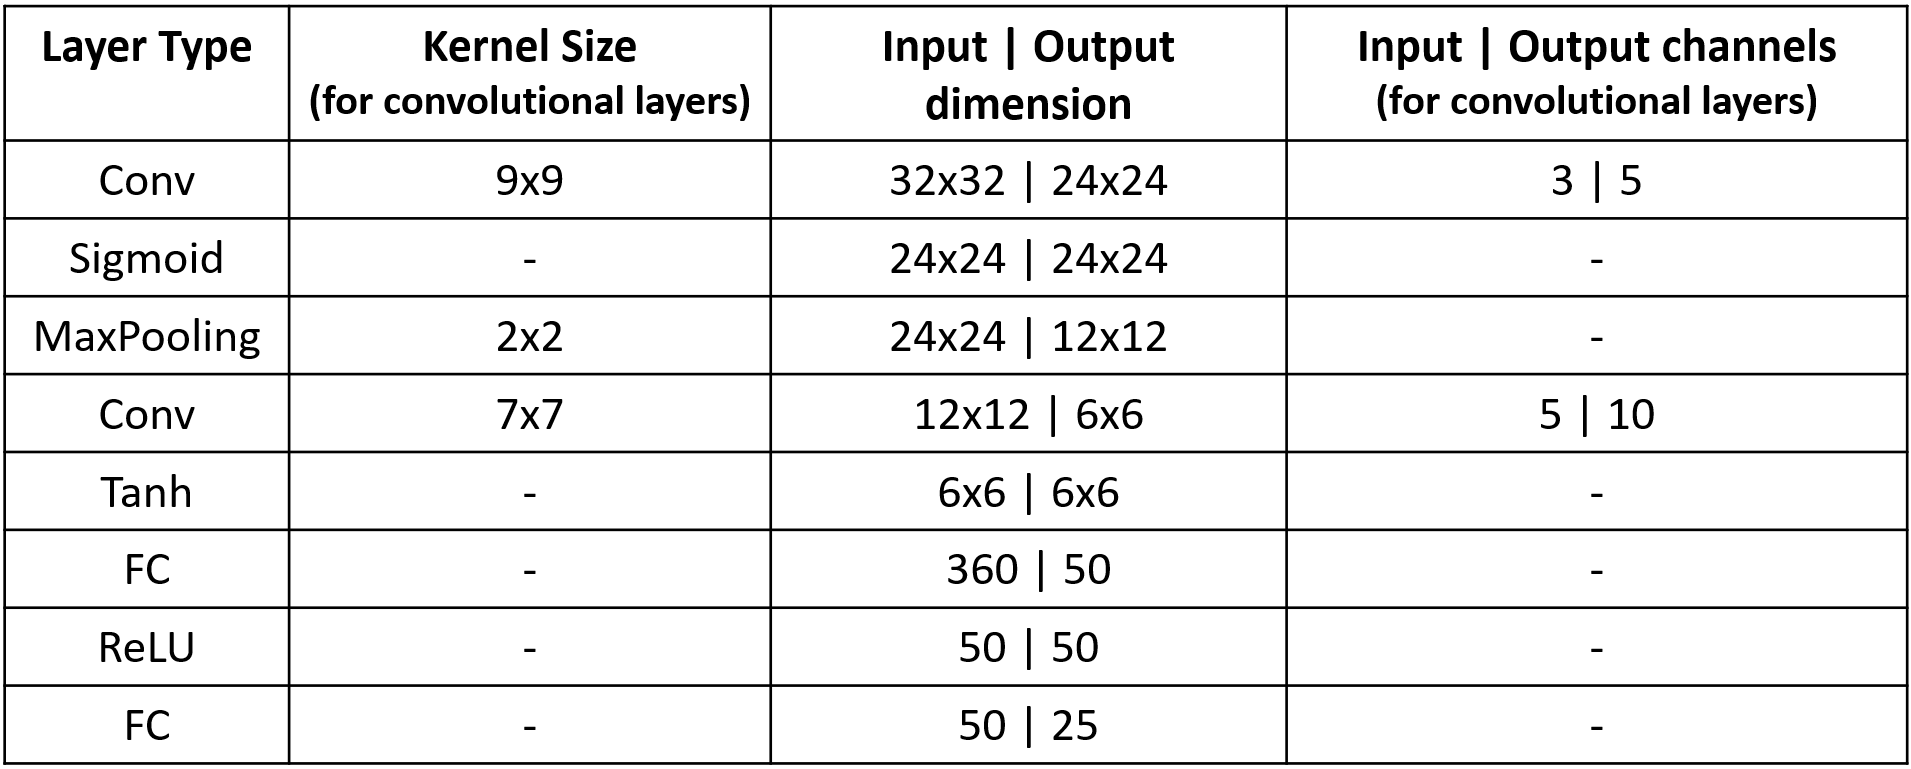

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



## 1.0 - Lectura de los datos

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/large_carnivores'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/food_con

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [ ]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/people ):  [Path('/root/.fastai/data/cifar100/train/people/boy'), Path('/root/.fastai/data/cifar100/train/people/man'), Path('/root/.fastai/data/cifar100/train/people/woman'), Path('/root/.fastai/data/cifar100/train/people/baby'), Path('/root/.fastai/data/cifar100/train/people/girl')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de clases dentro de superclase 

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/reptiles
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/household_furniture
/root/.f

In [ ]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/reptiles


Ahora intentamos verificar si los hemos eliminado realmente.

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [ ]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/people ):  [Path('/root/.fastai/data/cifar100/train/people/boy'), Path('/root/.fastai/data/cifar100/train/people/man'), Path('/root/.fastai/data/cifar100/train/people/woman'), Path('/root/.fastai/data/cifar100/train/people/baby'), Path('/root/.fastai/data/cifar100/train/people/girl')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock.

Se utilizará, como se ha indicado en el enunciado el 10% del entrenamiento como validación. Para asegurar que dicha división sea siempre la misma en todas las ejecuciones se ha pasado a RandomSplitter una semilla.

Elegiremos como tamaño de batch 32.
Es importante, para optimizar el uso de la GPU, utilizar como tamaño de batch una potencia de 2.
Los valores, para obtener una mejor generalización, se ha comprobado en, p.ej [[1]](https://arxiv.org/abs/1804.07612), que están entre 2 y 32. Uno de los valores más usuales es 32, por lo que utilizaremos ese valor en el resto de la práctica.

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


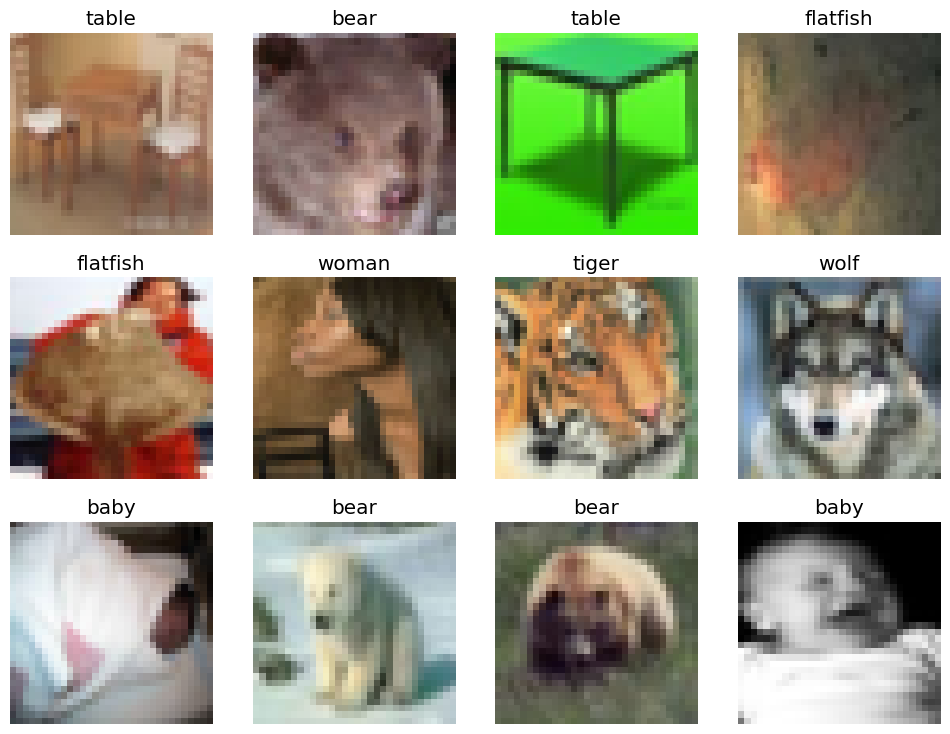

In [ ]:
# A CUBRIR POR EL ALUMNADO
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock), # Trabajamos con imágenes y predecimos categorías
                   get_items = get_image_files,             # Recuperamos las imágenes con la función get_image_files
                   get_y     = parent_label,                # Labels = Directorios en los que se encuentra cada imagen
                   splitter  = RandomSplitter (valid_pct=0.1, seed=42)) #Utilizamos un 10% de los datos para validación

# Especificamos la ruta donde se encuentran las imágenes y el tamaño del batch
dls = dblock.dataloaders(path/'train', bs=32)

dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Example of training data


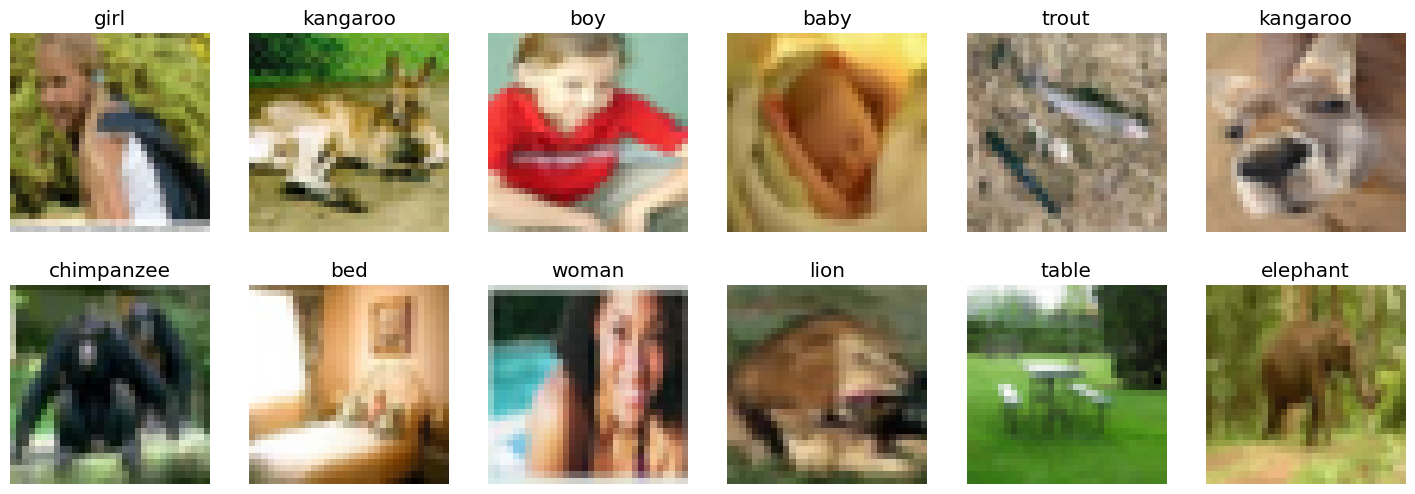

In [ ]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


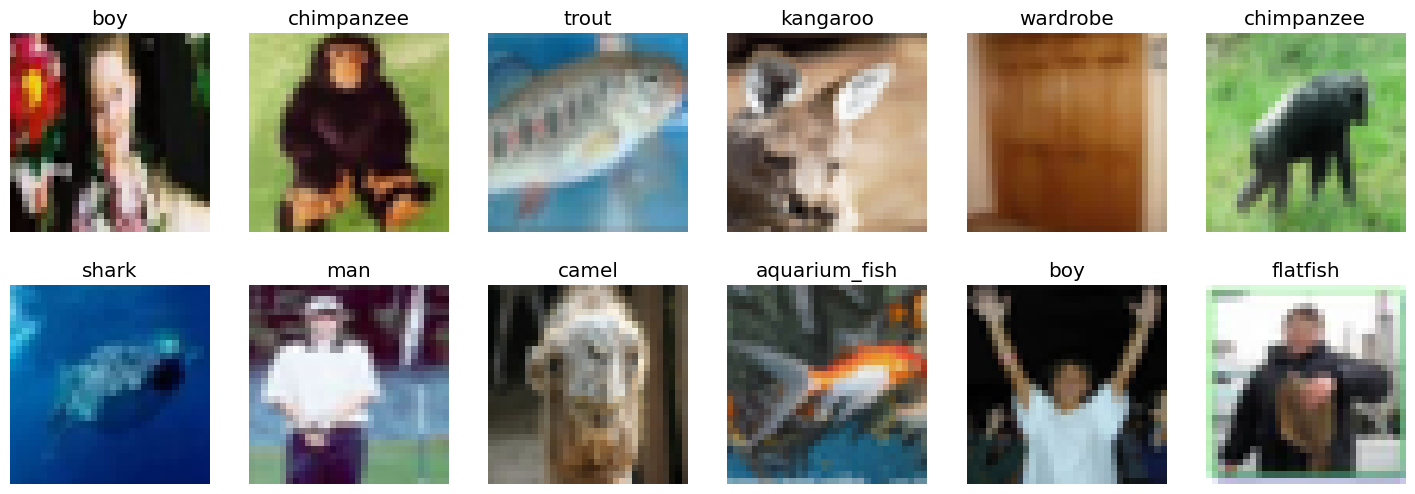

In [ ]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

## 1.1 - Creación de la red:

Ahora procedemos con la creación y entrenamiento de la red BaseNet.

Para ello, se utilizará la función *sequential* de fastai, que nos permite establecer una sucesión de capas, que se irán aplicando secuencialmente a nuestra imagen, y que constituirán nuestra red neuronal:

In [ ]:
from torch.nn import Linear, Sigmoid, Tanh, ReLU, Conv2d, Flatten
from torchsummary import summary

BaseNet = sequential(
    # A CUBRIR POR EL ALUMNADO
    Conv2d(3, 5, 9, bias=True),
    Sigmoid(),
    MaxPool (ks=2),
    Conv2d(5, 10, 7, bias=True),
    Tanh(),
    Flatten(),
    Linear(360, 50, bias=True),
    ReLU(),
    Linear(50, 25, bias=True)
)

summary(BaseNet.cuda(), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 24, 24]           1,220
           Sigmoid-2            [-1, 5, 24, 24]               0
         MaxPool2d-3            [-1, 5, 12, 12]               0
            Conv2d-4             [-1, 10, 6, 6]           2,460
              Tanh-5             [-1, 10, 6, 6]               0
           Flatten-6                  [-1, 360]               0
            Linear-7                   [-1, 50]          18,050
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 25]           1,275
Total params: 23,005
Trainable params: 23,005
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.16
---------------------------------------------

## 1.2 - Explicación capas modelo

Nótese que todas las capas se han tomado del módulo `nn` de PyTorch. Existen algunas implementaciones de estas capas en fastai (como ConvLayer), suelen añadir normalización, o en general, son más complejas que las básicas de PyTorch.

*  **Capa convolucional**:

   `Conv2d(kernel_size, in_channels, out_channels, bias=True or False)`
    
  Nótese que no estamos usando padding y el stride (paso del kernel) será de 1 por defecto, y por tanto en la primera capa convolucional reduciremos la dimensión de la imagen en 2 filas y 2 columnas (por usar un kernel 3x3). En la segunda capa convolucional reduciremos la imagen en 4 filas y 4 columnas (por usar un kernel 5x5).

*  **Funciones de activación (Sigmoide, Tanh, ReLU)**:

    Se aplica una función, elemento por elemento, a la entrada.
    * **Sigmoide**: La función sigmoide es la aplicación
$$ \sigma : \mathbb{R} \xrightarrow{} \mathbb{R} , \ \sigma(x) = \frac{1}{1+e^{-x}}$$

      Su característica más importante es que está acotada entre 0 y 1 (lo cual puede llevar al problema llamado desvanecimiento de gradientes, por ser su derivada en valores elevados en módulo, muy cercana a 0).

    * **Tangente hiperbólica**: La función tangente hiperbólica es la aplicación
$$ \tanh : \mathbb{R} \xrightarrow{} \mathbb{R} , \ \tanh(x) = \frac{\exp(x)-\exp(-x)}{\exp(x)+\exp(-x)}$$

      Función similar a la sigmoide: acotada entre 0 y 1, y con el mismo problema en la derivada.

    * **ReLU**: La función ReLU es la aplicación
    $$ \text{ReLU} : \mathbb{R} \xrightarrow{} \mathbb{R} , \text{ReLU}(x) = \max(0,x)$$

    Función de activación más usada actualmente en las redes neuronales, ya que elimina el problema del desvanecimiento de gradientes (aunque presenta otros problemas, como el llamado "dying ReLU units").

  Nótese que las tres funciones son no lineales, permitiendo así que nuestra red tenga la potencia suficiente para aproximar funciones no lineales (si las tres fueran lineales, nuestra red sería equivalente a una función lineal).

*  **MaxPool**:

  `MaxPool2d(kernel_size, stride=None, padding=0)`

  El principal objetivo de la capa de Maxpooling es reducir las dimensiones (filas y columnas) de la imagen de entrada.
  
  Para ello, utiliza un kernel de cierto tamaño $n\times n$ (sin parámetros a ajustar). En cada píxel de la imagen original (siempre que el stride sea 1), se elige, de entre un entorno de tamaño $n\times n$, el píxel con el valor más elevado. La imagen resultado estará formada por dichos píxeles con el valor máximo, reduciendo así n-veces el número de filas y columnas.

  El stride especifica el tamaño del paso del kernel, permitiendo disminuir aún más las dimensiones de la imagen.

*  **Flatten**:

  "Aplana" la imagen que recibe. Es decir, si recibe una imagen de dimensiones $l\times m\times n$ devuelve simplemente un vector de tamaño $l\cdot m \cdot n$.

*  **Linear**:

  Se trata de una capa completamente conectada o FC. Conecta cada neurona de la entrada con todas las neuronas de la salida. Matemáticamente, se está aplicando la siguiente transformación afín:
  $$
  output = input \cdot weight^T + bias
  $$

  , donde $weight$ es la matriz de pesos.

  Son las capas que, en general, aportarán el mayor número de parámetros a la red, por lo que deberemos tener cierta precaución al incluirlas.

La especificación de las capas se ha extraído de la [documentación del módulo nn de Pytorch](https://pytorch.org/docs/stable/nn.html).

En todas las capas que procede (Convolucional y FullyConnected) se ha considerado usar bias para darle más flexibilidad al modelo. Sin embargo, también provocará que tengamos que ajustar bastantes más parámetros.

***Decisiones implementación:***

Nuestro problema es un problema de clasificación multiclase.

Por tanto, la función de pérdida será algún tipo de Entropía Cruzada (Crossed Entropy). Asimismo, la función de activación de la última capa debería ser una Softmax, que nos devolverá las probabilidades de que la imagen pertenezca a cada clase.

En Pytorch y fastai, existen dos tipos de funciones de pérdida básicas de Entropía Cruzada: *CrossEntropy* y *CrossEntropyFlat*. La versión Flat realizará un flattening ("aplanado") de la entrada y de las predicciones. Deberemos usar esa versión Flat para que nuestras salidas tengan más sentido (y realmente tengamos una única clase predicha para cada imagen).

No será necesario implementar SoftMax en la última capa, por el simple hecho de que cualquiera de las funciones anteriores, aplica SoftMax para calcular la función de pérdida. Según la [documentación de Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):

`Note that this case is equivalent to applying LogSoftmax on an input, followed by NLLLoss.`

Es decir, el método combina la aplicación de una función Softmax y el cálculo de la pérdida o loss.

De hecho, cualquiera de esas funciones espera la salida sin aplicar SoftMax, es decir, de nuevo en la documentación de Pytorch:

`The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general)`


## 1.3 - Cálculo de parámetros del modelo

Como hemos podido comprobar en la salida anterior, la arquitectura se corresponde con la estructura de la red que queríamos implementar. Repasemos el número de parámetros y el tamaño de la salida que aparece en cada capa:
- Ni en las capas en las que simplemente se aplica una función de activación (ReLu, Tanh, Sigmoid), ni en las capas de MaxPooling es necesario calcular los parámetros de un kernel, por lo que dichas capas no añaden ningún parámetro.
- En las capas de función de activación simplemente se aplica una función de activación elemento por elemento, por lo que las dimensiones de la imagen no cambian. En cambio, MaxPooling reduce las dimensiones de la imagen a la mitad tomando el máximo de un entorno de píxeles (el tamaño de dicho entorno estará determinado por un kernel). En este caso, se reduce el número de filas y columnas a la mitad ya que se utiliza un kernel de 2x2 (el número de canales no cambia).
- Capa Convolucional (`ks = 9, input_channels = 3, output_channels = 5`): Por cada canal, entrenaremos el número de parámetros del kernel (es decir, 9x9x3 en este caso). Además, como añadimos 1 bias, entrenaremos 9x9x3+1 parámetros. Como queremos que la salida tenga 5 canales, el número de parámetros será 5 veces lo anterior, es decir:
$$
5\cdot (9\cdot 9 \cdot 3 + 1) = 1220
$$
Al no haber añadido padding, se perderán (ks-1)/2 filas por arriba y (ks-1)/2 filas por abajo (y lo mismo ocurrirá con el número de columnas por la izquierda y por la derecha). Por tanto, el número de filas y de columnas de la imagen será:
$$
32 - (9-1) = 24
$$
- Capa Convolucional (`ks = 7, input_channels = 5, output_channels = 10`): el número de parámetros a determinar serán, como en el caso anterior:
$$
10\cdot (7\cdot 7 \cdot 5 + 1) = 2460
$$
El número de filas y columnas de la imagen resultante será:
$$
12 - (7-1) = 6
$$

- La capa Flatten simplemente recibe la imagen y la "aplana", es decir, la convierte en un vector 1D. Como recibe una imagen con dimensiones 6x6x10, su salida es simplemente un vector 1D de tamaño 6x6x10.

- La primera capa FullyConnected (o Linear), conecta las 360 entradas que recibe con 50 salidas. Como están completamente conectadas, se deberán determinar 360x50 parámetros, y en cada salida habrá un bias que determinar, lo que hace un total de:
$$
360\cdot 50 + 50 = 18050
$$

- La última capa FullyConnected (o Linear), conecta completamente las 50 entradas que recibe con 25 salidas. Como en el caso anterior, el número de parámetros en esta capa será de:
$$
50\cdot 25 + 25 = 1275
$$

El número de parámetros de la red será, por tanto:
$$
1220+2460+18050+1275 = 23005
$$

## 1.4 - Entrenamiento del modelo y evaluación





Creamos un objeto Learner de fastai, que incluirá al modelo, los datos (DataLoader), la función de pérdida, y la métrica (en nuestro caso, utilizaremos más de una, para conseguir una mayor comprensión del funcionamiento del modelo):

In [ ]:
from sklearn.metrics import precision_score, recall_score

learn = Learner(
    dls,
    BaseNet,
    metrics=[
        accuracy,
        Precision(average='weighted'), # Si a ninguna imagen se le ha predicho una clase, Precision = 0.0
        Recall(average='weighted'),
        F1Score(average='weighted')
    ],
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

Podemos elegir muchas métricas, entre las que destacan las más comunes, que son Accuracy, Sensitivity o Recall, Precision, Specificity y F1-score.

El **accuracy** medirá la proporción de aciertos del modelo respecto a todas las predicciones del modelo. Es bastante interesante para comprobar cómo funciona el modelo, especialmente en problemas como este, donde las clases están balanceadas.

**Sensitivity o Recall** se define en general como la proporción de positivos, de entre todos los casos verdaderamente positivos, que se han detectado correctamente.

Resulta interesante combinar Recall con **Precision**, que se define como la proporción de positivos, de entre todos los casos predichos como positivos por la red, que se han detectado correctamente.

Para tener una medida del funcionamiento global del modelo, podemos calcular la media armónica de Precision y Recall, para obtener el **F1-score**.

En el caso de un problema multiclase, las tres métricas anteriores tienen 3 versiones: macro (calculándola para cada clase, y calculando el promedio), micro (calculándola en general con todos los ejemplos) y weighted (ponderando el tamaño de cada clase). Por ser un problema bastante balanceado, las tres versiones serán prácticamente equivalentes.

Se ha optado por no usar **Specificity**, que se define para cada clase como la proporción de negativos que se han predicho correctamente respecto al total de negativos. En general, es una métrica que se usa bastante menos, ya que pone el foco en los casos negativos.


Se elige Adam como optimizador, que es el optimizador más usado en el entrenamiento de redes neuronales (a pesar de ser AdamW una versión corregida), ya que introduce el término de momento, concepto similar a la inercia, que permite escapar de los óptimos locales en gran parte de las ocasiones.

También introduce weight decay (regularizador que penaliza que los pesos tengan valores elevados), aunque en este caso no se utilizará, ya que es una red relativamente pequeña y en principio no parece que vayamos a necesitar usar regularización de este tipo.

Utilizamos EarlyStopping, de manera que cuando el error en validación aumente durante 5 épocas seguidas, se detiene el entrenamiento y se restaura el modelo a su mejor versión.

La función `learn.fit_one_cycle` entrena la red durante un cierto número de épocas usando la técnica de 1 ciclo de Leslie N. Smith [[2]](https://arxiv.org/abs/1708.07120).

En dicha técnica, se intenta combinar un learning rate elevado con un momento reducido, y viceversa. Para ello, el learning rate comienza a incrementarse a medida que avanza el número de iteraciones, mientras que el momento va disminuyendo.

Para poder determinar un valor de learning rate que permita que el entrenamiento se realice a un buen ritmo, sin diverger podemos utilizar la función `learn.lr_find()`:

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

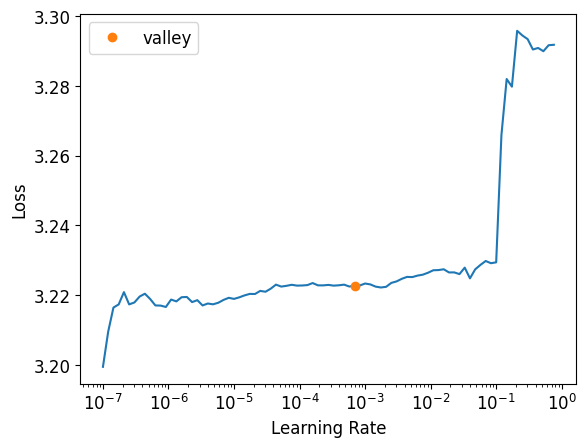

In [ ]:
lr = learn.lr_find()

In [ ]:
print(lr[0])

0.0006918309954926372


La gráfica anterior es bastante distinta de lo que podíamos esperar. No hay ningún valor para el que se muestre una disminución clara de la pérdida, lo cual nos puede anticipar que el entrenamiento no va a ser muy bueno, especialmente en la primera época.

Comprobamos que para cierto valor suficientemente elevado del learning rate, la función de pérdida aumenta mucho. No nos interesa tomar un valor cercano a ese gran aumento, ya que puede provocar que nuestro entrenamiento diverja.

No está claro que exista un valor para el que el aprendizaje se acelere (máxima pendiente), y la sugerencia que nos da el método (valley) parece que se encuentra en una zona con una pendiente cercana a 0. No parece que exista un valor mucho mejor, por lo que podemos quedarnos con el que nos sugiere (nótese que no podemos determinar de ninguna forma qué valor es el óptimo, por lo que nos quedamos con una estimación que tenga cierto sentido).

Pasamos al entrenamiento:

In [ ]:
learn.fit_one_cycle(25, lr_max = lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,3.221532,3.221504,0.033600,0.001256,0.033600,0.002421,00:18
1,3.207394,3.193177,0.049600,0.031972,0.049600,0.025278,00:16
2,3.010670,2.950683,0.140000,0.077705,0.140000,0.073684,00:15
3,2.906421,2.841136,0.159200,0.127345,0.159200,0.116653,00:16
4,2.839914,2.804619,0.177600,0.190540,0.177600,0.147290,00:15
5,2.773298,2.731999,0.193600,0.169192,0.193600,0.164971,00:17
6,2.702222,2.680732,0.204800,0.210149,0.204800,0.170301,00:15
7,2.652452,2.639441,0.216000,0.193129,0.216000,0.185563,00:17
8,2.616986,2.613285,0.228800,0.224666,0.228800,0.206622,00:15
9,2.569246,2.567955,0.232000,0.206604,0.232000,0.202017,00:15


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Primeramente, como aclaración, en la ejecución anterior, se muestran algunas advertencias, ya que en las primeras épocas, existen ciertas clases a las que nuestra red no asigna ninguna imagen, y por tanto en lugar de dividir por 0 en el cálculo de precision, simplemente se toma como precision de esa clase = 0.

Algo interesante del entrenamiento anterior es que en validación los valores que se obtienen en todas las métricas (f1, precision, recall y accuracy) son muy similares, llegando al final del entrenamiento a tener un valor muy cercano al 30%. Que los valores sean tan similares es algo esperable, debido a que todas las clases están balanceadas, y por tanto la red no muestra preferencias por ninguna clase.

También resulta interesante comentar la rapidez del entrenamiento, debido a la gran simplicidad de la red.

Para comentar la pérdida de entrenamiento y en validación resulta interesante mostrar la curva de aprendizaje de nuestra red:

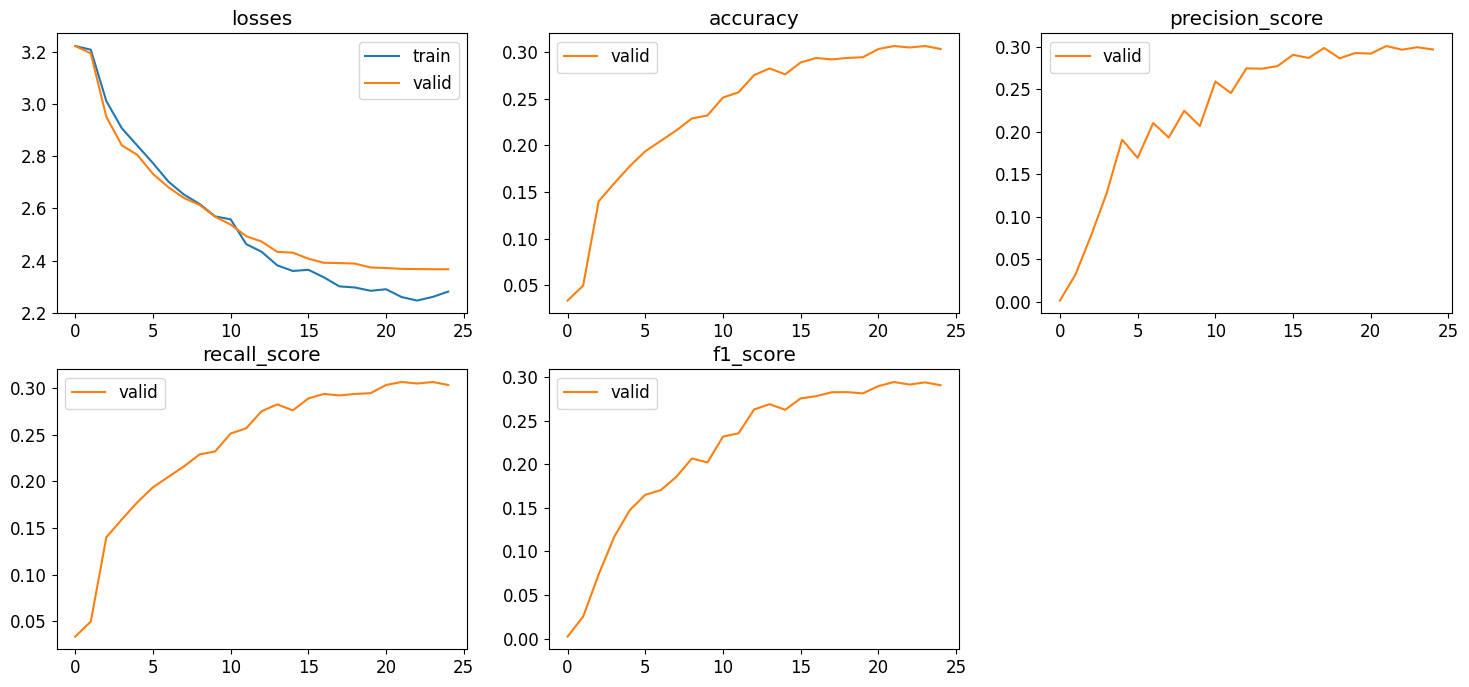

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
preds, targs = learn.get_preds(dl=dls.train)
train_accuracy = accuracy(preds, targs)
print(f'Accuracy en entrenamiento = {train_accuracy.item()}')

preds, targs = learn.get_preds(dl=dls.valid)
val_accuracy = accuracy(preds, targs)
print(f'Accuracy en validación = {val_accuracy.item()}')

Accuracy en entrenamiento = 0.3263111114501953


Accuracy en validación = 0.30320000648498535


Nos centramos en la curva de aprendizaje (la primera de las gráficas anteriores). En primer lugar, podemos observar que nuestro modelo está aprendiendo, ya que el error en entrenamiento y en validación va disminuyendo a medida que aumenta el número de épocas. Asimismo, se observa como las distintas métricas en validación (accuracy, precision, recall y f1) van aumentando a medida que aumenta el número de épocas.

También observamos que el ritmo de aprendizaje es bastante rápido, lo que indica una buena inicialización de los pesos iniciales, y una buena elección de la tasa de aprendizaje. Podemos observar, a partir de la época 10, que existe cierto sobreajuste a los datos del entrenamiento, ya que el error en entrenamiento continúa disminuyendo, pero el error de validación comienza a estancarse en un cierto valor. Aun así, el sobreajuste es mínimo debido a la simplicidad de nuestra red.

Podemos también comprobar que durante las últimas épocas el error en validación y entrenamiento apenas disminuye, por lo que el entrenamiento se puede dar con bastante seguridad por concluido, aunque se podría entrenar durante 2 o 3 épocas más (nótese que el entrenamiento ha concluido en las 25 épocas, no por EarlyStopping). Esto mismo ocurre con las métricas en validación, que van aumentando hasta que llegan a un cierto valor, alrededor de la época 20, donde ya no aumentan más.

Como se ha comentado anteriormente, todas las métricas en evaluación son muy similares entre ellas, llegando a superar ligeramente en todos los casos a 0.3.

El valor de accuracy en entrenamiento y validación van en esa línea, sobrepasando en ambos casos el 30%, siendo en validación un valor ligeramente inferior. Podemos ver que los valores son muy similares, lo que nos muestra que nuestra red generaliza bastante bien al conjunto de validación.

Por poner un poco en contexto, un clasificador aleatorio tendría un accuracy de:
$$
\frac{1}{\text{número de clases}} = \frac{1}{25} = 0.04
$$

, por lo que a pesar de ser un modelo muy básico, obtener un 30% de aciertos teniendo 25 clases no es tan sencillo de conseguir. Sin embargo, y como demostraremos en el ejercicio 2, es un resultado que se puede mejorar bastante.

Para entender mejor cómo funciona nuestro modelo básico, representaremos la matriz de confusión:

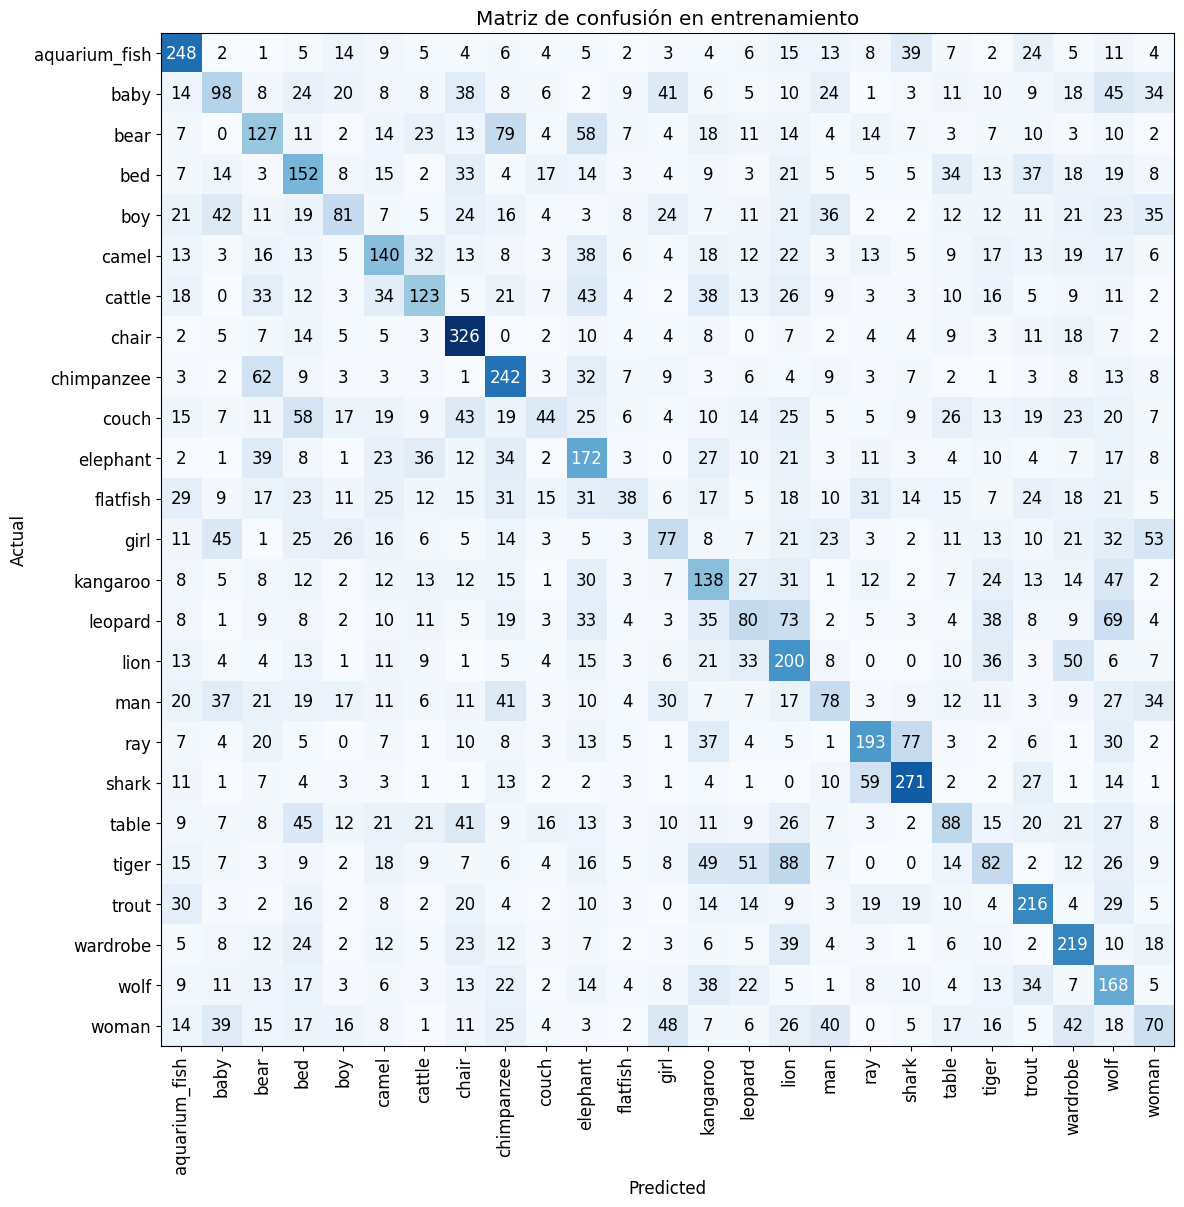

In [ ]:
# ENTRENAMIENTO --> ds_idx = 0
interp = ClassificationInterpretation.from_learner(learn, ds_idx=0)
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en entrenamiento')

La matriz de confusión nos muestra los errores y aciertos que comete nuestra red en las distintas clases. En el eje horizontal se representa la predicción de nuestra red, mientras que en el eje vertical se representa la etiqueta real de dicha imagen.

Por tanto, es importante notar que en la diagonal se encuentran las imágenes cuya etiqueta coincide con la predicción de nuestra red, es decir, las imágenes clasificadas correctamente por nuestra red.

En el conjunto de entrenamiento, existían unas 500 imágenes por clase (no llega a 500, ya que parte de ellas se destinaron a validación), por tanto, los números de cada fila sumarán ~500.

Aunque existen alguna clases, como la silla (chair) que nuestra red clasifica bastante bien, obteniendo entre 50-60% de acierto, existen muchas clases que nuestra red confunde bastante, ya que podemos observar bastantes zonas fuera de la diagonal con valores elevados. Por ejemplo, nuestra red confunde bastante las imágenes de tigres con la clase león, o las imágenes de osos con la clase chimpancé. De hecho, podemos mostrar cuáles son las clases que más confunde:


In [ ]:
interp.most_confused(min_val=50)

[('tiger', 'lion', 88),
 ('bear', 'chimpanzee', 79),
 ('ray', 'shark', 77),
 ('leopard', 'lion', 73),
 ('leopard', 'wolf', 69),
 ('chimpanzee', 'bear', 62),
 ('shark', 'ray', 59),
 ('bear', 'elephant', 58),
 ('couch', 'bed', 58),
 ('girl', 'woman', 53),
 ('tiger', 'leopard', 51),
 ('lion', 'wardrobe', 50)]

Para entender un poco mejor el funcionamiento de nuestro modelo, mostramos finalmente las imágenes que más contribuyen a la pérdida (que recordemos era la entropía cruzada):

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


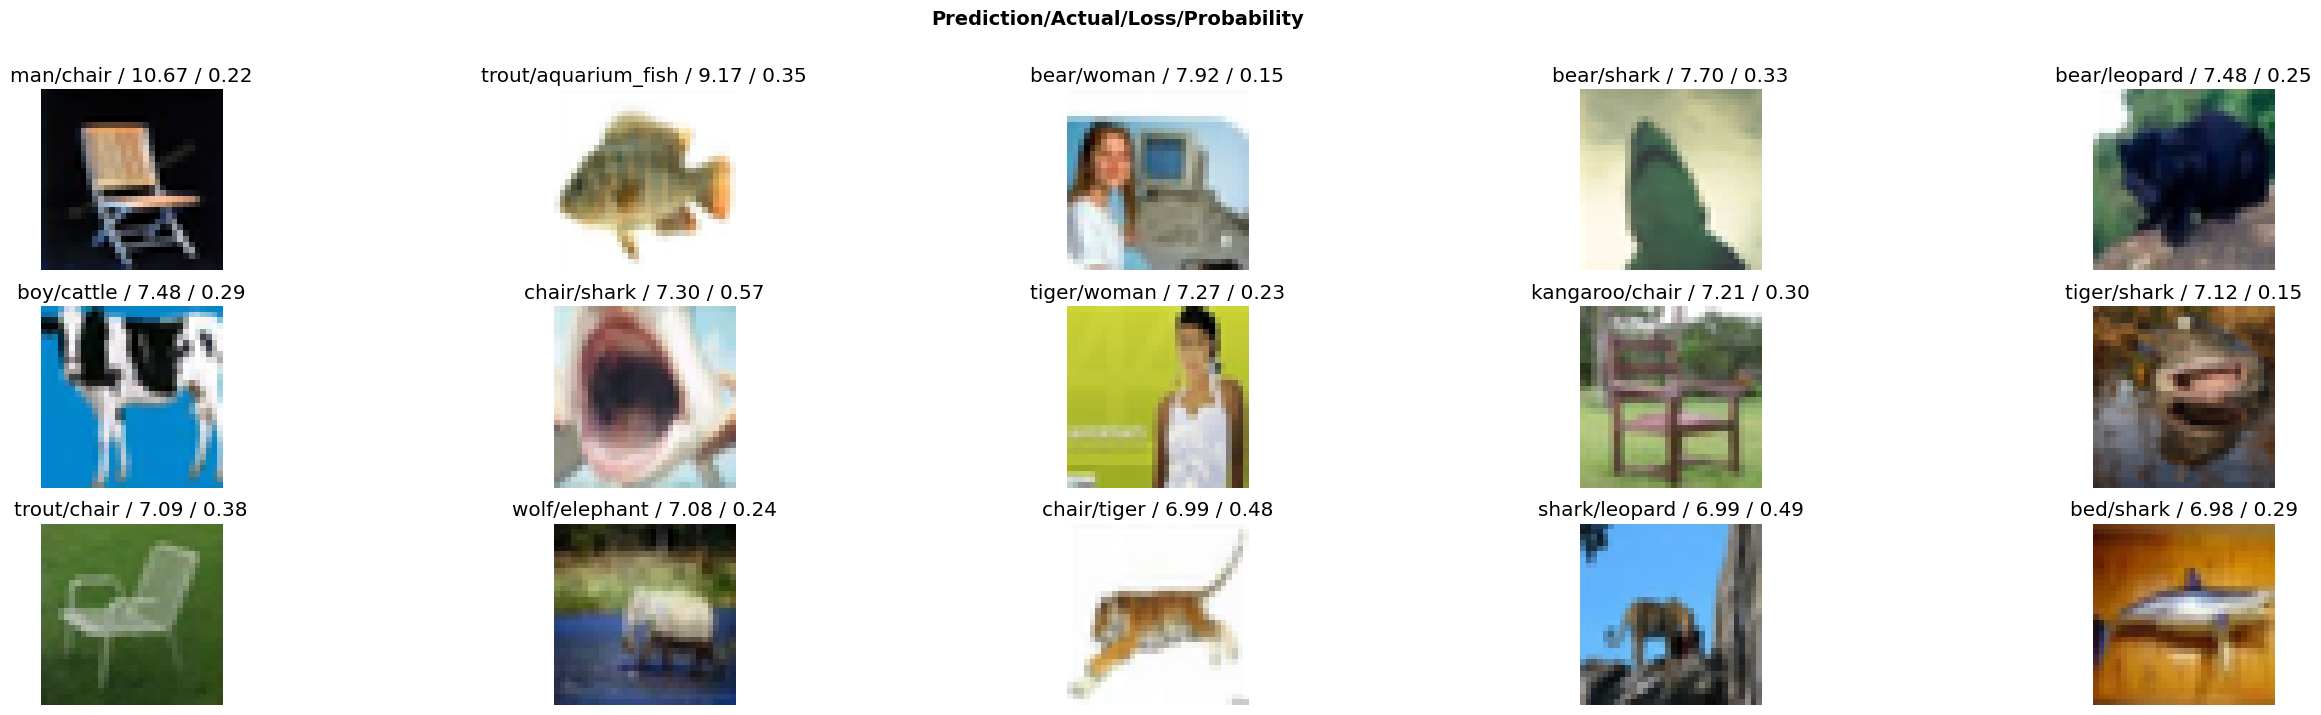

In [ ]:
interp.plot_top_losses(15, nrows=3, figsize=(32,8))

Salvo en algunos casos, como la confusión del pez de acuario con una trucha, en la mayoría de casos son errores difíciles de comprender. No podemos llegar a comprender cómo la red confunde por ejemplo la imagen de la vaca con un niño, o cómo confunde a un tiburón con una cama.

Mostramos ahora la matriz de confusión en validación:

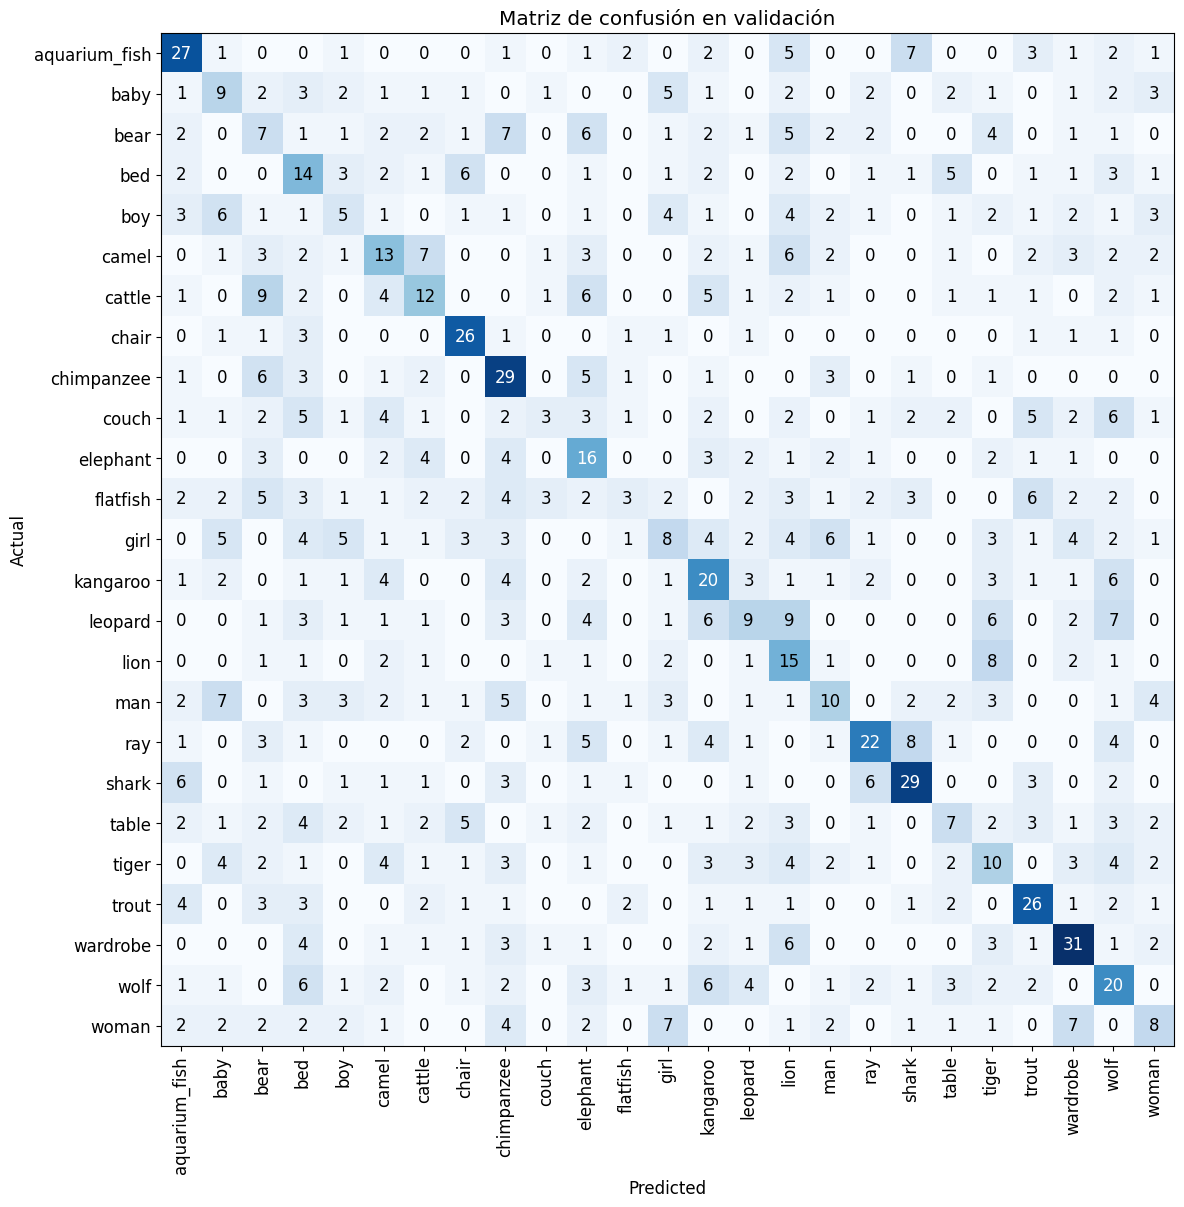

In [ ]:
# VALIDACIÓN --> ds_idx = 1
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en validación')

La matriz de confusión obtenida en validación es muy similar a la obtenida en entrenamiento, y todo lo dicho para el entrenamiento se puede aplicar a este caso. Hay muchas zonas fuera de la diagonal con valores bastante elevados, y en general, esas zonas coinciden con las vistas en la matriz del entrenamiento.

Esto nos muestra que el conjunto de validación tiene una dificultad similar a la del conjunto de entrenamiento, y que nuestro modelo tiene un rendimiento similar en el entrenamiento y en la validación.

Por analogía, veamos cuáles son los ejemplos que más contribuyen a la función de pérdida en este caso:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


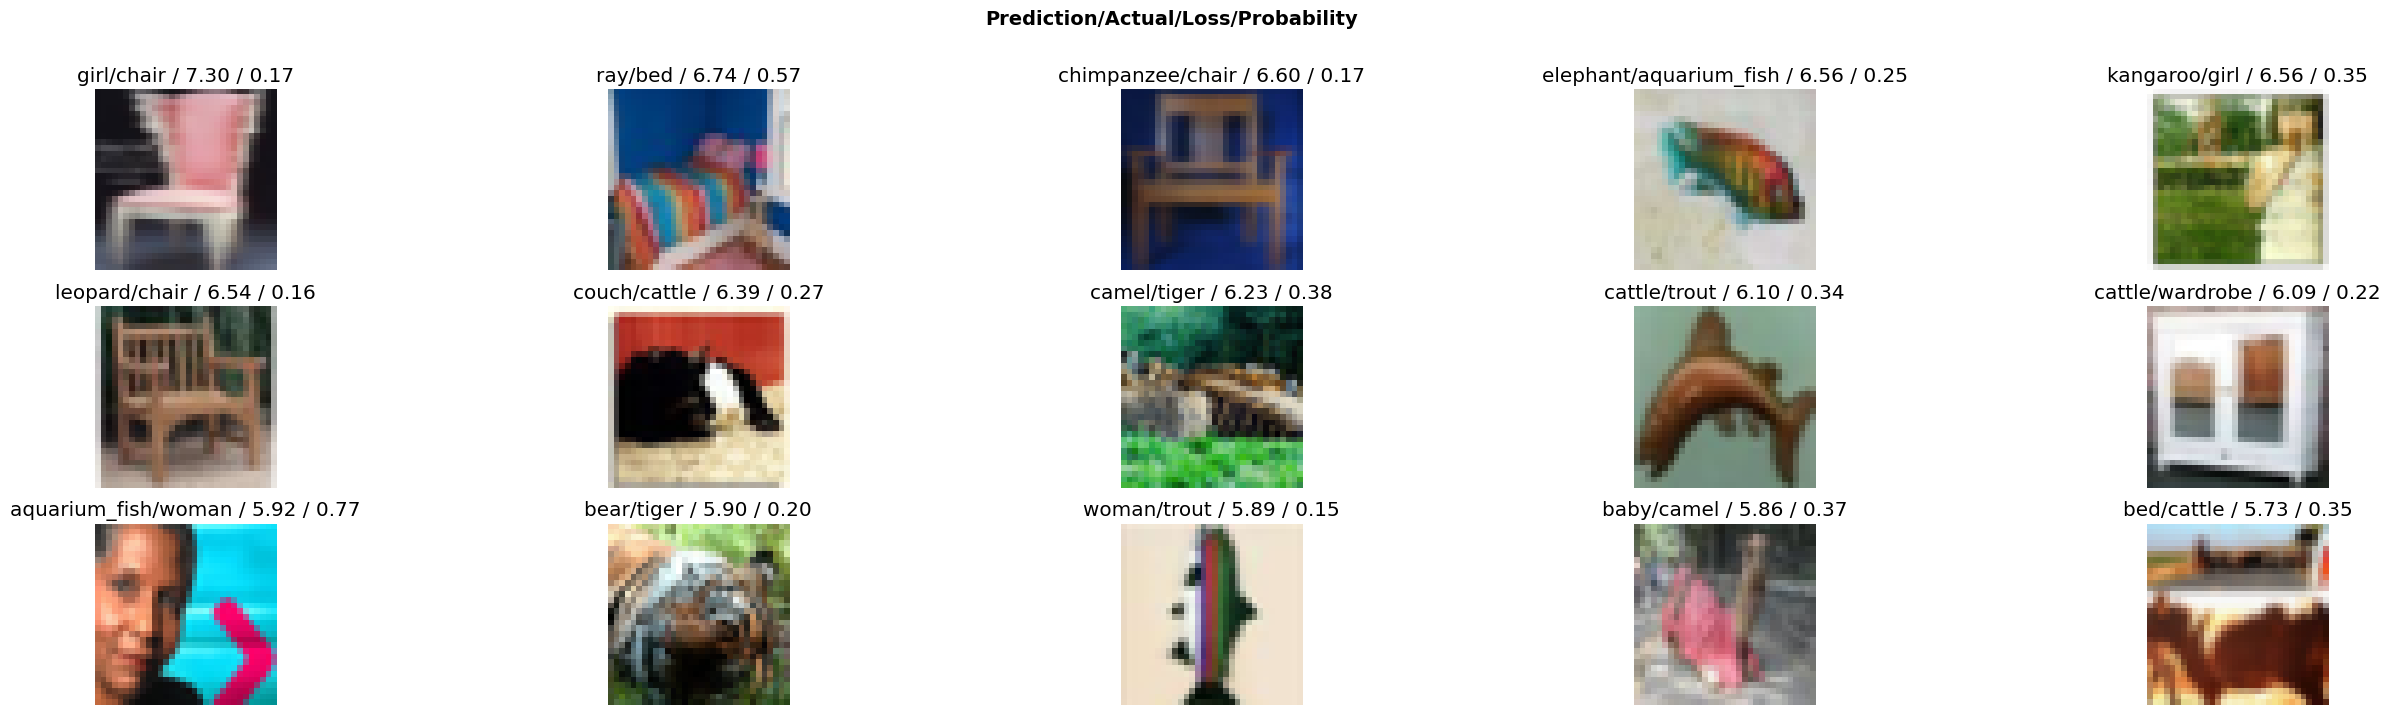

In [ ]:
interp.plot_top_losses(15, nrows=3, figsize=(32,8))

De nuevo, los errores son, en su mayoría bastante difíciles de entender.
No se entiende muy bien cómo la red puede llegar a confundir una mantaraya con una cama, o  a una mujer con un pez de acuario.

## 1.5 - Evaluación con el conjunto de test

Evaluamos ahora el funcioanamiento de nuestro modelo ya entrenado. Para ello, recuperamos nuestro conjunto de test:

In [ ]:
dls_test = learn.dls.test_dl(files_test, with_labels = True)

Calculamos la accuracy en test:

In [ ]:
preds, targs, _ = learn.get_preds(dl = dls_test, with_decoded = True)
test_accuracy = accuracy(preds, targs)
print(f'Accuracy en test = {test_accuracy.item()}')

Accuracy en test = 0.28760001063346863


Se obtiene un valor muy cercano al obtenido en validación, llegando prácticamente al 30% de accuracy. Hemos comprobado, por tanto, que la generalización de nuestro modelo es bastante buena, ya que los resultados obtenidos en entrenamiento, son prácticamente idénticos a los obtenidos en el test.

Aun así, dista mucho de lo que consideraríamos una buena clasificación, ya que a bastantes más de la mitad de imágenes se les coloca una etiqueta incorrecta. De hecho, como hemos comprobado, esa etiqueta, en general, se confunden incluso clases que no tienen ninguna similitud.

Visualizamos la matriz de confusión en el test:

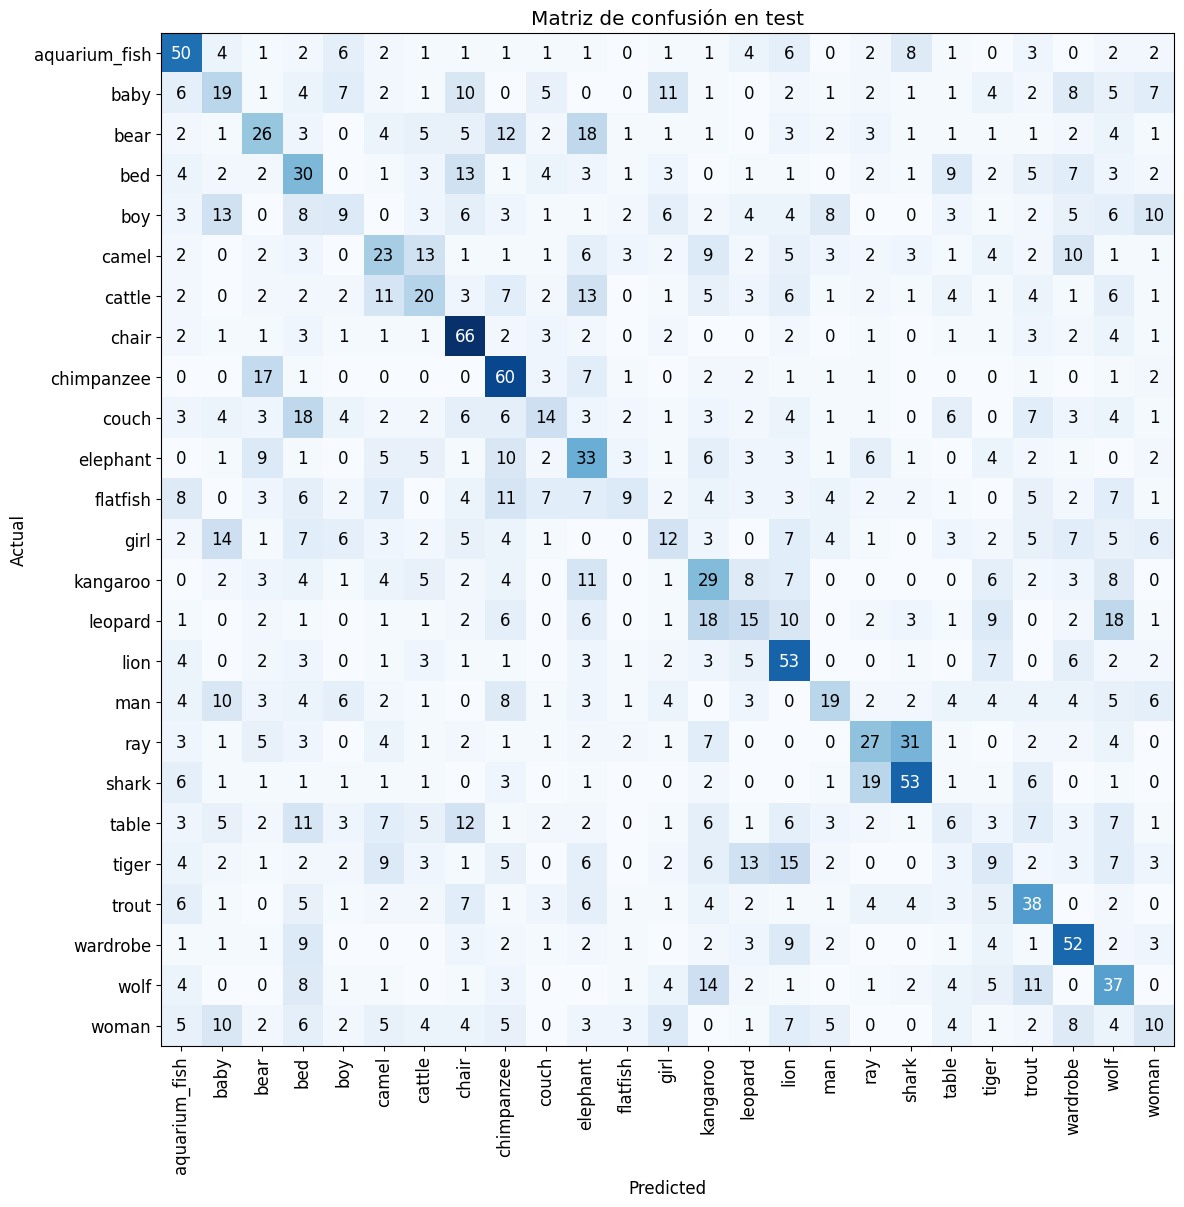

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, dl = dls_test)
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en test')

La matriz de confusión sigue en la línea de las vistas en entrenamiento y evaluación. Pocas clases bien clasificadas (silla, chimpancé), y la mayoría con números bastante elevados fuera de la diagonal.

Podemos destacar p.ej el caso de la clase mesa (table), que solo tienen en su fila, una entrada con 0. Es decir, se llega a confundir dicha clase con otras 23, en al menos una ocasión.



---



---



---



# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


## 2.0 - Normalización de los datos

Aunque no será un cambio en la arquitectura, en este caso sí que normalizaremos las imágenes antes de comenzar a trabajar con ellas. Es decir, les restaremos su media y dividiremos por su desviación típica.

En dicho proceso, se calculará la media y la desviación típica en el entrenamiento y se normalizará realizando el cálculo anterior. Utilizando esos mismos valores (sin recalcularlos) se normalizará el conjunto de test.

El motivo de usar normalización es claro: no solo permite que todo lo que se calcule afectará a todas las características por igual, sino que también está comprobado que acelera el entrenamiento, por lo que parece lógico aplicarlo.

Utilizaremos para normalizar las imágenes y que no sea necesario calcular las estadísticas de nuestras imágenes, las estadísticas ya disponibles en fastai del conjunto CIFAR:

In [ ]:
dblock = DataBlock(
                          blocks     = (ImageBlock, CategoryBlock),
                          get_items  = get_image_files,
                          splitter   = RandomSplitter(valid_pct = 0.1, seed = 42),
                          get_y      = parent_label,
                          batch_tfms = Normalize.from_stats(*cifar_stats)    # Normalización
                      )

dls = dblock.dataloaders(path/'train', bs = 32)

## 2.1 - Cambio a ReLU y modificación de los filtros

### 2.1.1 - Cambio a ReLU

La primera mejora que se nos puede ocurrir al observar la arquitectura del ejercicio 1, es sustituir la presencia de funciones de activación Sigmoide y Tanh por funciones ReLU.

Sabemos que esto mejorará el entrenamiento, ya que las funciones anteriormente mencionadas tienen, para valores pequeños y grandes, una derivada que es prácticamente 0. Esto provoca un problema al entrenar la red mediante backpropagation, ya que los cálculos que se realizan son derivadas usando la regla de la cadena, por lo que si uno de los factores es muy cercano a 0, el producto total será prácticamente 0 y el entrenamiento será muy lento.

La alternativa más usada en la actualidad es ReLU (aunque también tiene otros problemas como sabemos, [dying ReLU](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)), ya que además acelera bastante el entrenamiento por ser una función mucho más simple. Por tanto, nuestra arquitectura quedaría en principio como:

| Tipo de Capa  | Tamaño del Kernel (para capas convolucionales) | Dimensión de Entrada | Dimensión de Salida | Canales de Entrada | Canales de Salida |
|----------------|-----------------------------------------------|----------------------|---------------------|---------------------|-------------------|
| Conv           | 9x9                                           | 32x32                | 24x24               | 3                   | 5                 |
| ReLU            | -                                             | 24x24                | 24x24               | -                   | -                 |
| MaxPooling     | 2x2                                           | 24x24                | 12x12               | -                   | -                 |
| Conv           | 7x7                                           | 12x12                | 6x6                 | 5                   | 10                |
| ReLU            | -                                             | 6x6                  | 6x6                 | -                   | -                 |
| FC             | -                                             | 360                  | 50                 | -                   | -                 |
| ReLU           | -                                             | 50                  | 50                  | -                   | -                 |
| FC             | -                                             | 50                   | 25                  | -                   | -                |

### 2.1.2 - Cambios en los filtros

En este apartado modificaremos la estructura de la red, centrándonos en los filtros de las capas convolucionales de la red BaseNet.

Como se detalla en [[3]](https://cs231n.github.io/convolutional-networks/#architectures), uno de los fallos de nuestra arquitectura es que estamos perdiendo información (especialmente en los bordes) muy rápidamente, ya que no estamos utilizando padding en las convoluciones. Por tanto, será interesante utilizar padding en cada una de las convoluciones de nuestra red, de manera que la reducción de dimensiones solo se realice en las capas de Pooling.

Otro fallo que estamos cometiendo es utilizar filtros excesivamente grandes en las convoluciones. Como se dice en [[3]](https://cs231n.github.io/convolutional-networks/#architectures), *Prefer a stack of small filter CONV to one large receptive field CONV layer*. Disminuiremos el número de parámetros y nos permitirá expresar más características interesantes de la entrada. Se recomienda, por tanto, usar filtros de 3x3, y a lo sumo, de 5x5.

Gran parte de las arquitecturas actuales, como ResNet, utilizan en las convoluciones filtros de 3x3, por lo que nosotros optaremos por ese tamaño también.

Incorporaremos además una capa de Pooling tras la segunda convolución para poder reducir la dimensionalidad (que hemos perdido al poner padding en la segunda convolución), y de esta forma no aumentar tanto la cantidad de parámetros de la red. Incorporando lo anterior nos quedaría:


| Tipo de Capa  | Tamaño del Kernel (para capas convolucionales) | Dimensión de Entrada | Dimensión de Salida | Canales de Entrada | Canales de Salida |
|----------------|-----------------------------------------------|----------------------|---------------------|---------------------|-------------------|
| Conv           | 3x3                                           | 32x32                | 32x32               | 3                   | 32                 |
| ReLU            | -                                             | 32x32                | 32x32               | -                   | -                 |
| MaxPooling     | 2x2                                           | 32x32                | 16x16              | -                   | -                 |
| Conv           | 3x3                                          | 16x16                | 16x16                 | 32                   | 64                |
| ReLU            | -                                             | 16x16                  | 16x16                 | -                   | -                 |
| MaxPooling     | 2x2                                           | 16x16                | 8x8              | -                   | -                 |
| FC             | -                                             | 4096                  | 50                 | -                   | -                 |
| ReLU           | -                                             | 50                  | 50                  | -                   | -                 |
| FC             | -                                             | 50                   | 25                  | -                   | -                |

Algo que hemos notado en el ejercicio 1, es que nuestra red no tiene la complejidad suficiente para conseguir resolver el problema de las imágenes.

Lo primero que podemos notar es que las capas convolucionales de la arquitectura tienen una cantidad muy pequeña de filtros convolucionales (únicamente 5 en la primera capa y 10 en la segunda). La cantidad de filtros convolucionales suele ser una potencia de 2 [[4]](https://aman.ai/cs231n/cnn/), para poder vectorizar correctamente.

Si observamos arquitecturas recientes, como ResNet, los valores que se suelen usar son 32, 64, 128, 256 o 512; por lo que podríamos usar algunos de esos valores. Además, se suelen usar de manera creciente, es decir, en las capas anteriores se incluye un número de filtros menor que en capas posteriores. Esto se puede deber a que las imágenes suelen ser bastante ruidosas, por lo que tiene sentido extraer en principio pocas características, y a medida que avanzamos y obtenemos características más puras, las combinamos de forma más compleja. Existen diversos experimentos donde se comprueban que de esta forma se obtienen mejores resultados [[5]](https://www.researchgate.net/publication/342999107_The_Impact_of_Filter_Size_and_Number_of_Filters_on_Classification_Accuracy_in_CNN).

Para no aumentar el número de parámetros enormemente, nos quedaremos en principio con valores pequeños, como 32 y 64. Comprobemos que el rendimiento de la red mejora ahora:

Creamos el nuevo modelo:

In [ ]:
from torch.nn import Linear, ReLU, Conv2d, Flatten, Dropout, BatchNorm2d, BatchNorm1d
from torchsummary import summary

ImprovedNet1 = sequential(
    Conv2d(3, 32, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Conv2d(32, 64, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Flatten(),
    Linear(4096, 50, bias=True),
    ReLU(),
    Linear(50, 25, bias=True)
)

In [ ]:
from sklearn.metrics import precision_score, recall_score

learn = Learner(
    dls,
    ImprovedNet1,
    metrics=[
        accuracy,
        Precision(average='weighted'), # Si a ninguna imagen se le ha predicho una clase, Precision = 0.0
        Recall(average='weighted'),
        F1Score(average='weighted')
    ],
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 32 x 32   
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 64 x 16 x 16   
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 8 x 8     
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 4096   

Seleccionamos una tasa de aprendizaje adecuada:

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

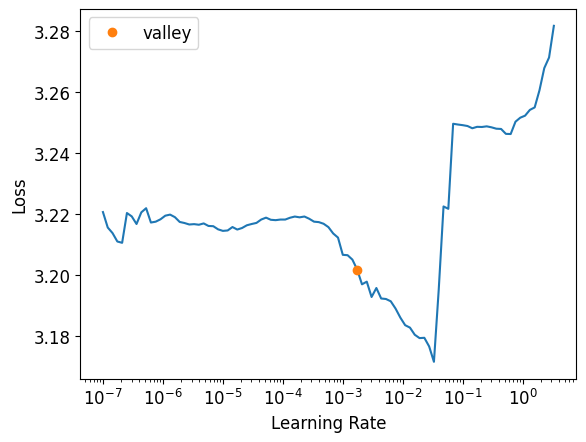

In [ ]:
lr = learn.lr_find()

Observamos que un valor entre, aproximadamente `1e-4` y `1e-2` sería adecuado para el entrenamiento. El valor sugerido por la función `lr_find` parece bastane adecuado, ya que nos encontramos con una pendiente decreciente bastante pronunciada, por lo que en principio elegimos ese valor para el entrenamiento.

In [ ]:
learn.fit_one_cycle(25, lr_max = lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.925430,2.826416,0.162400,0.210888,0.162400,0.127449,00:15
1,2.543122,2.475999,0.273600,0.354946,0.273600,0.244805,00:15
2,2.289936,2.236423,0.343200,0.350463,0.343200,0.317956,00:15
3,2.080650,2.059378,0.394400,0.415262,0.394400,0.389771,00:15
4,1.875069,2.030067,0.386400,0.467240,0.386400,0.384340,00:15
5,1.629583,1.878559,0.437600,0.452857,0.437600,0.431612,00:15
6,1.400085,1.985687,0.423200,0.465291,0.423200,0.416455,00:15
7,1.119745,2.002225,0.442400,0.471933,0.442400,0.444434,00:14
8,0.869509,2.260411,0.447200,0.479621,0.447200,0.450069,00:14
9,0.661120,2.425821,0.443200,0.476702,0.443200,0.449198,00:14


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


No improvement since epoch 5: early stopping


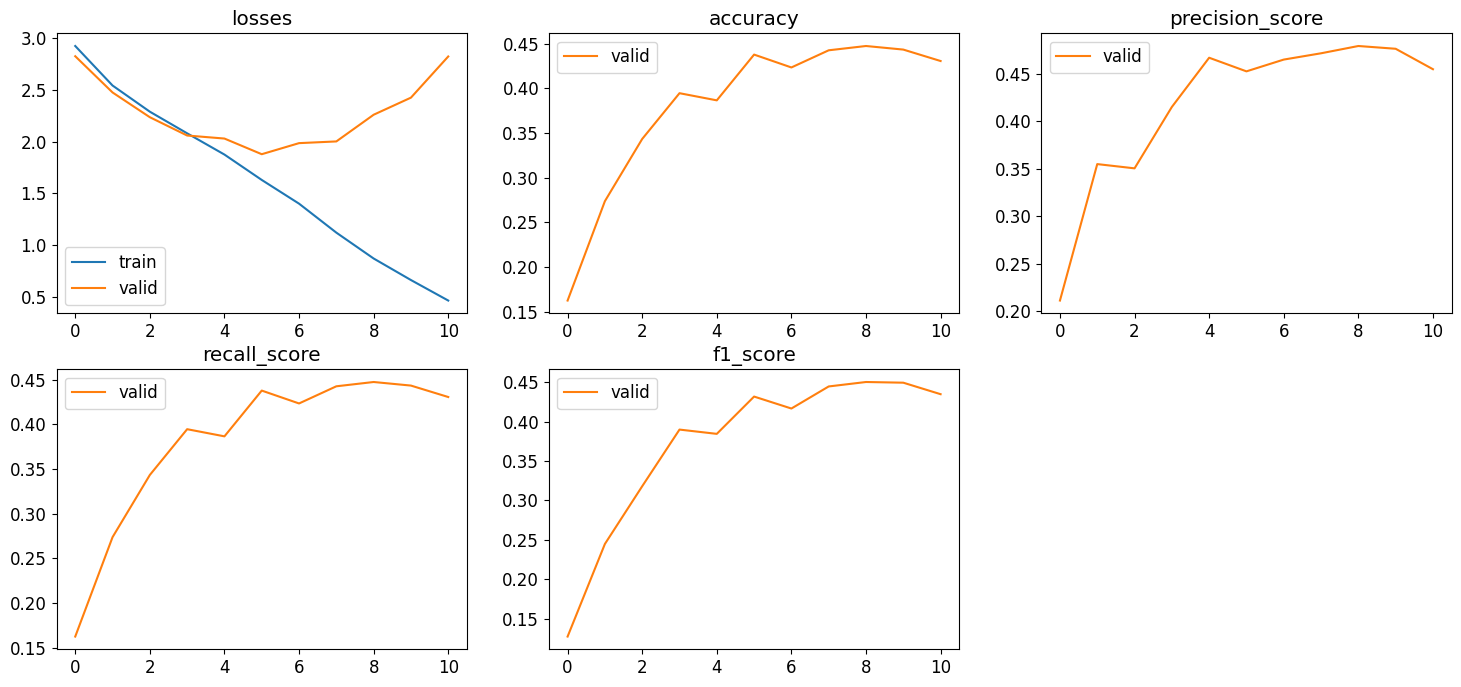

In [ ]:
learn.recorder.plot_metrics()

Comprobamos en la curva de aprendizaje que el error en entrenamiento disminuye rápidamente, y el error es mucho menor que en el caso anterior. También, en la época 5, se alcanza en validación un error mucho más pequeño que en el modelo base (1.87 frente a 2.37).

En cuanto al accuracy, llegamos a obtener, casi 0.45 en la época 5 (y lo mismo ocurre en el resto de métrica), lo cual indica que nuestro modelo ha mejorado bastante, debido a un incremento de potencia, por el aumento del número de filtros, lo cual ha permitido extraer más características de la imagen inicial.

Sin embargo, la curva de aprendizaje anterior, muestra que el aumento en el número de filtros, y con ello el número de parámetros (especialmente en la primera capa FC) provoca un enorme sobreajuste a los datos de entrenamiento. A partir de la época 5, el error en entrenamiento sigue disminuyendo a un ritmo muy rápido, mientras que el error en validación no para de aumentar. Para continuar mejorando el modelo, deberemos corregir este sobreajuste de alguna forma.

## 2.2 - Dropout


Para lidiar con el sobreajuste, una idea interesante sería utilizar Dropout [[6]](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf), [[7]](https://arxiv.org/pdf/1207.0580), es decir, durante el entrenamiento, desactivamos una parte $p$ de las neuronas, de manera que dichas neuronas no entrenan, y por tanto, reducimos el sobreajuste, ya que el número de neuronas a entrenar se reduce enormemente. Durante el test, dichas neuronas se vuelven a activar (multiplicando la salida por $p$, por la sobreexcitación de la red, al encontrarse con neuronas que no estaban en el entrenamiento), lo que provoca un aumento de la potencia de la red, y por tanto un mejor rendimiento en validación.

En el paper original de Dropout se recomienda utilizar $p = 0.5$, *our usual default value of 0.5 is close to optimal*, por lo que será el valor que utilizaremos.

En principio, como nuestras dos capas convolucionales son bastante sencillas, aplicaremos Dropout en las capas Fully Connected (que es de hecho como se aplica en [[7]](https://arxiv.org/pdf/1207.0580)), que tienen muchos parámetros. En caso de observar que continuara el overfitting, lo aplicaríamos en más capas:

In [ ]:
from torch.nn import Linear, ReLU, Conv2d, Flatten, Dropout, BatchNorm2d, BatchNorm1d
from torchsummary import summary

ImprovedNet2 = sequential(
    Conv2d(3, 32, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Conv2d(32, 64, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Flatten(),
    Dropout(0.5),
    Linear(4096, 50, bias=True),
    ReLU(),
    Dropout(0.5),
    Linear(50, 25, bias=True)
)

In [ ]:
from sklearn.metrics import precision_score, recall_score

learn = Learner(
    dls,
    ImprovedNet2,
    metrics=[
        accuracy,
        Precision(average='weighted'),
        Recall(average='weighted'),
        F1Score(average='weighted')
    ],
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 32 x 32   
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 64 x 16 x 16   
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 8 x 8     
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 4096   

Calculamos una posible tasa de aprendizaje:

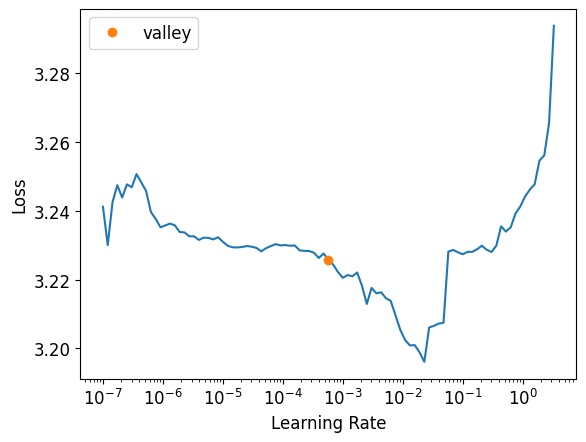

In [ ]:
lr = learn.lr_find()

Parece que valores entre `1e-4` y algo menos de `1e-2` podrían ser interesantes, ya que en ellos se observa una disminución de la función de pérdida. De nuevo, el valor sugerido parece bastante correcto:

In [ ]:
learn.fit_one_cycle(25, lr_max = lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.997231,2.882410,0.180800,0.141343,0.180800,0.128521,00:14
1,2.753087,2.503779,0.270400,0.286903,0.270400,0.240708,00:15
2,2.590528,2.377775,0.345600,0.346919,0.345600,0.321032,00:14
3,2.465659,2.248041,0.334400,0.372265,0.334400,0.312495,00:14
4,2.437533,2.127938,0.357600,0.373917,0.357600,0.328708,00:14
5,2.416076,2.146571,0.358400,0.364801,0.358400,0.329207,00:15
6,2.402361,2.195783,0.332000,0.390874,0.332000,0.318890,00:14
7,2.333489,2.084239,0.364800,0.392521,0.364800,0.358727,00:15
8,2.268406,2.035572,0.364800,0.410189,0.364800,0.348934,00:15
9,2.227093,2.006958,0.380800,0.424804,0.380800,0.363252,00:15


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


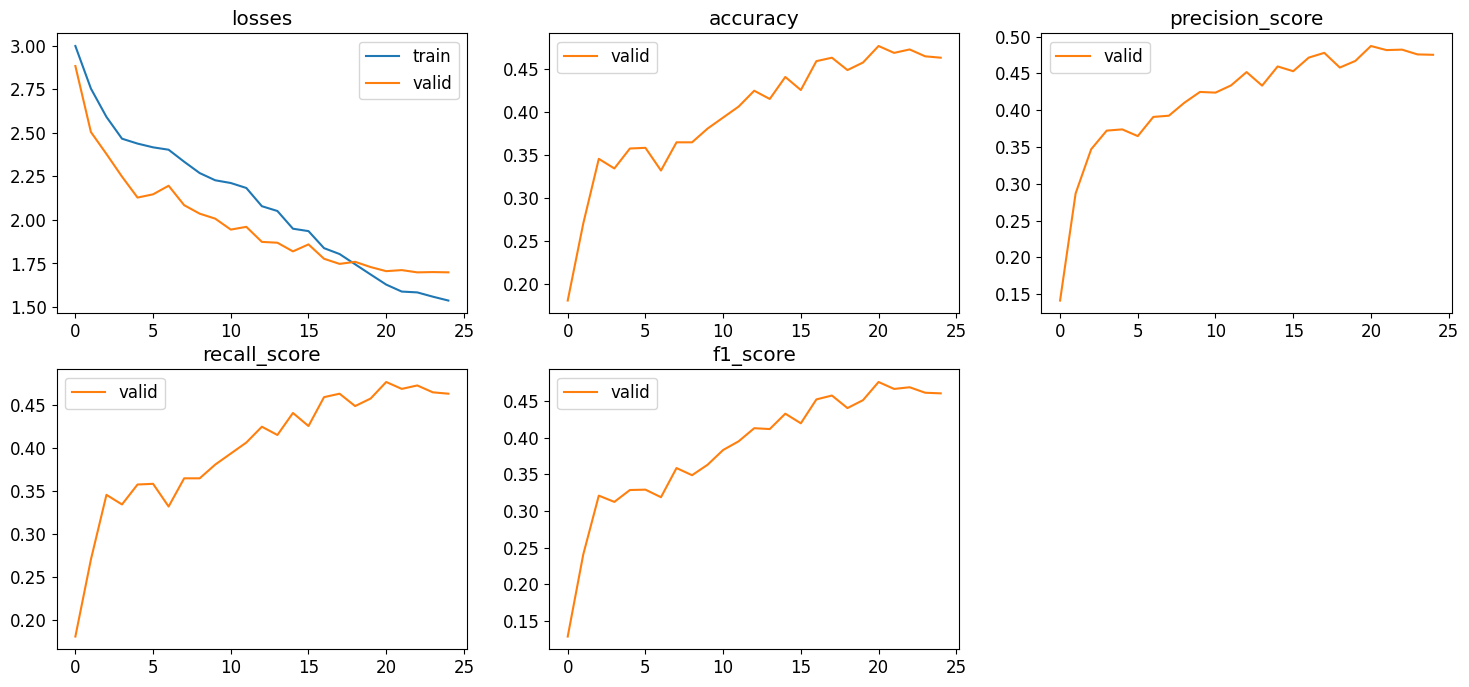

In [ ]:
learn.recorder.plot_metrics()

Los resultados mejoran bastante. La incorporación de Dropout nos muestra (gráfica A) que el overfitting desaparece por completo. De hecho, en gran parte del entrenamiento, Dropout provoca que el error en validación sea menor que en el entrenamiento.

No solo eliminamos el gap entre Entrenamiento y Validación, sino que además, mejoramos nuestro resultado en accuracy, obteniendo más del $45\%$ de acierto. Lo mismo ocurre con el F1 score, que supera a 0.45 en el conjunto de validación.

A pesar de nuestros avances, parece que la red necesita una mayor capacidad para poder alcanzar más de un 60% de accuracy en validación.

## 2.3 - Aumento del número de capas de la red

Una de las formas de aumentar la capacidad de la red de aproximar funciones más complejas es aumentar la profundidad de la red. De hecho, en competiciones como ILSVRC, se ha ido aumentando la profundidad de las redes a medida que han ido pasando los años ("Revolution of Depth").

Hay varios motivos que explican este aumento progresivo de la profundidad. En primer lugar, permite establecer una estructura jerárquica en la que en las primeras capas de aprenden características a muy bajo nivel (bordes, esquinas, ...), y en las siguientes capas dichas características se van combinando para crear características mucho mśa complejas, como objetos o texturas.

En segundo lugar, un mayor número de capas provoca un aumento en el tamaño del campo receptivo, es decir, la región de la entrada que la red convolucional observa para decidir cada salida. Con una única capa convolucional con un filtro 3x3, por ejemplo, observaríamos unas 9 posiciones para decidir cada salida. Arquitecturas recientes, como AlexNet, observa hasta 195 posiciones, mientras que las más actuales, como Inception, tienen un campo receptivo de 3039. Aumentar el campo receptivo se ha comprobado que es necesario para tareas de clasificación a alto nivel [[8]](https://distill.pub/2019/computing-receptive-fields/).







Deberemos ahora decidir cómo aumentar el número de capas de la red. Como se comenta en [[3]](https://cs231n.github.io/convolutional-networks/#architectures), una arquitectura común en las redes convolucionales es una repetición de la estructura:

> [CONV -> RELU]*N -> POOL

, donde CONV indica capa convolucional, RELU función de activación ReLU y POOL una capa de Pooling, y  *N indica una repetición N veces (N >= 1).

Aunque se usó durante bastante tiempo AveragePooling para disminuir la dimensión de la imagen, a día de hoy casi todas las arquitecturas utilizan MaxPooling, debido a que crea cierta invarianza a las traslaciones [[9]](https://medium.com/geekculture/max-pooling-why-use-it-and-its-advantages-5807a0190459#:~:text=Max%20Pooling%20is%20an%20operation,to%20filter%20size%20and%20strides.).

El motivo de realizar varias convoluciones antes de realizar el pooling es bastante importante en las primeras capas, ya que permite desarrollar características más complejas de la entrada antes de la "destrucción" de la operación de pooling.

Por tanto, antes de realizar la primera operación de pooling, realizaremos dos convoluciones (las dos que ya teníamos implementadas). Para aumentar el número de capas, añadiremos otras dos convoluciones, cada una seguida de la función RELU y POOL. Como comentamos en el apartado 1, queremos que el número de filtros vaya aumentando a medida que avanzamos en la red, por lo que las siguientes capas tendrán un número aun mayor de filtros (pasamos de 64 a 128).

Algo que puede también afectar a las características extraídas por la red es que la primera capa FC es muy destructiva (pasaríamos de 2048 entradas a 50). Esto puede provocar una gran pérdida de información. De hecho, en arquitecturas populares, como VGGNet, se suele pasar de 4096 o 2048 a 1024 en la primera de las capas densas.

Esto incrementaría mucho el número de parámetros, por lo que nosotros pasaremos únicamente de 50 salidas a 200 salidas.

Nuestro modelo queda de la siguiente forma:

In [ ]:
from torch.nn import Linear, ReLU, Conv2d, Flatten, Dropout, BatchNorm2d, BatchNorm1d
from torchsummary import summary

ImprovedNet3 = sequential(
    Conv2d(3, 32, 3, padding = 'same', bias=True),
    ReLU(),
    Conv2d(32, 64, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Conv2d(64, 128, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Conv2d(128, 128, 3, padding = 'same', bias=True),
    ReLU(),
    MaxPool (ks=2),
    Flatten(),
    Dropout(0.5),
    Linear(2048, 200, bias=True),
    ReLU(),
    Dropout(0.5),
    Linear(200, 25, bias=True)
)

In [ ]:
from sklearn.metrics import precision_score, recall_score

learn = Learner(
    dls,
    ImprovedNet3,
    metrics=[
        accuracy,
        Precision(average='weighted'), # Si a ninguna imagen se le ha predicho una clase, Precision = 0.0
        Recall(average='weighted'),
        F1Score(average='weighted')
    ],
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 32 x 32   
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 32 x 32   
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 16 x 16  
Conv2d                                    73856      True      
ReLU                                                           
______________________________________________

Decidimos una tasa de aprendizaje para nuestra red. Utilizamos de nuevo la función lr_find:

0.0012022644514217973

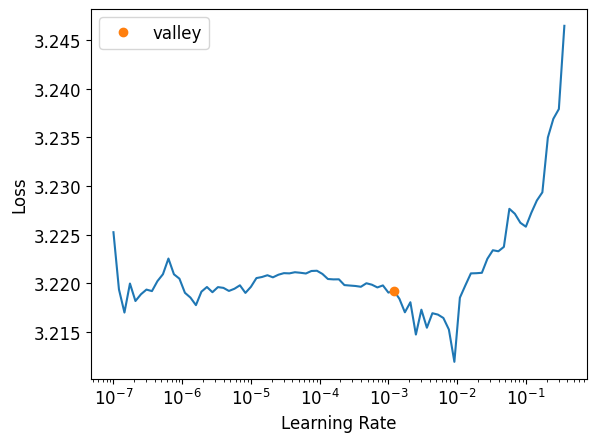

In [ ]:
lr = learn.lr_find()
lr[0]

Se podría elegir una tasa de aprendizaje con un valor cercano a 1e-3, donde se encuentra cierto descenso de la función de pérdida (aunque es muy inestable), y está aun bastante lejos del aumento de la función de pérdida. Parece que `1e-3` es un valor correcto, y es el valor que utilizaremos:

In [ ]:
learn.fit_one_cycle(25, lr_max = 1e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,3.027212,2.918602,0.145600,0.110768,0.145600,0.081363,00:15
1,2.815371,2.682845,0.212800,0.231348,0.212800,0.174058,00:16
2,2.583119,2.469444,0.265600,0.279115,0.265600,0.236564,00:16
3,2.405410,2.253201,0.317600,0.340128,0.317600,0.291962,00:25
4,2.256392,2.102750,0.357600,0.406782,0.357600,0.347436,00:17
5,2.080766,2.055975,0.381600,0.434135,0.381600,0.371600,00:18
6,1.893876,1.878052,0.442400,0.458437,0.442400,0.426431,00:19
7,1.771709,1.682719,0.472000,0.505966,0.472000,0.466968,00:16
8,1.627309,1.604939,0.517600,0.536940,0.517600,0.514357,00:19
9,1.501466,1.624950,0.492800,0.517511,0.492800,0.483128,00:15


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


No improvement since epoch 16: early stopping


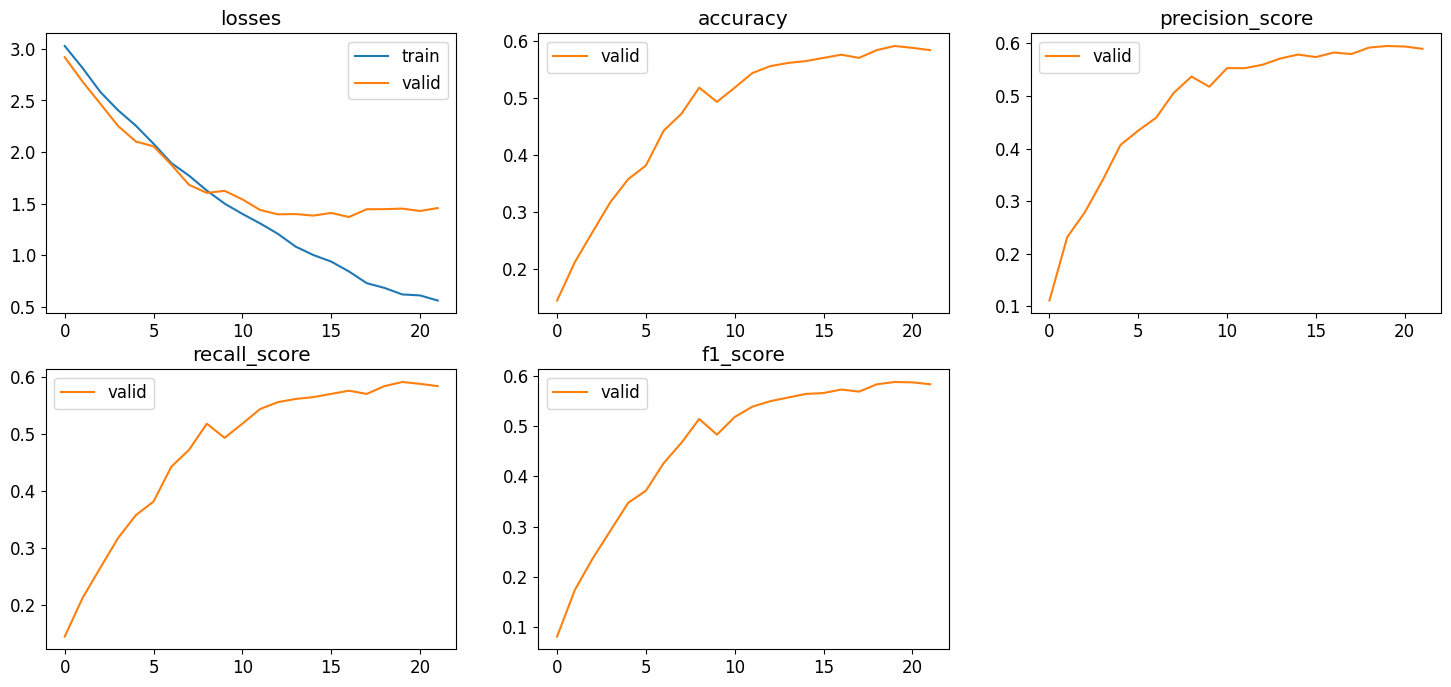

In [ ]:
learn.recorder.plot_metrics()

Observamos de nuevo la curva de aprendizaje. La función de pérdida en entrenamiento y validación alcanza un valor bastante más reducido que en los casos anteriores (training: 0.56 frente a 1.54 y validación:	1.45 frente a 1.70). Durante las 10 primeras épocas, el error en validación es menor que el error en entrenamiento, lo cual muestra que el Dropout de la etapa anterior sigue haciendo efecto.

Sin embargo, a partir de la época 8, la pérdida en entrenamiento comienza a disminuir, mientras en validación apenas cambia. Es decir, el aumento del número de capas ha provocado que nuestra red vuelva a tener cierto sobreajuste (de hecho, no hemos podido completar las 25 épocas del entrenamiento por el EarlyStopping).

También observamos un aumento bastante grande en las métricas utilizadas en validación, obteniendo ya un accuracy y f1-score cercanos a $0.6$. Es decir, podemos concluir que únicamente nos quedaría realizar una pequeña mejora de la red, y conseguir cerrar un poco el "gap" entre entrenamiento y validación, para alcanzar el $65\%$ de accuracy que buscamos.  

## 2.4 - Batch Normalization y Modelo final

En nuestra red actual, la distribución de las entradas de cada capa cambia durante el entrenamiento. Esto provoca que debamos ser muy cuidadosos con la inicialización de los parámetros de la red, y que necesitemos muchas épocas de entrenamiento para conseguir una mejora significativa.

Como solución a este problema, aparece Batch Normalization. Primeramente, se calcula la media y la desviación típica del mini-batch y se normalizan los datos. Para dar flexibilidad al entrenamiento de la red, se aprenderán dos parámetros, $\gamma,\beta$, que permiten cambiar la media y desviación de la distribución.

BN puede conseguir ayudarnos con el problema del sobreajuste del apartado anterior ya que, tal y como se detalla en el paper original, [[10]](https://arxiv.org/pdf/1502.03167), BN consigue regularizar el modelo, reduciendo la fuerza del overfitting, o incluso haciéndolo desaparecer. Además, BN nos permitirá usar tasas de aprendizajes mayores, y que la inicialización de la red no sea tan importante.

El paper original fue publicado en 2015, pero aun a día de hoy, la mayor parte de las arquitecturas más actuales, como GoogleNet utilizan esta estrategia para mejorar el entrenamiento.

En general, se suele usar justo antes de aplicar la función de activación, tal y como recomienda el paper original de Ioffe y Szegedy (ambos exinvestigadores de Google, y actuales investigadores de xAI). Nosotros seguiremos esa recomendación, usando `BatchNorm2d` tras cada convolución (2D) y usando `BatchNorm1d` tras cada capa FC (salvo en la capa de salida).

Nuestro modelo final queda por tanto, de la siguiente forma:

| Tipo de Capa  | Tamaño del Kernel (para capas convolucionales) | Dimensión de Entrada | Dimensión de Salida | Canales de Entrada | Canales de Salida |
|----------------|-----------------------------------------------|----------------------|---------------------|---------------------|-------------------|
| Conv           | 3x3                                           | 32x32                | 32x32               | 3                   | 32                 |
| Batch Normalization           | -                                           | 32x32                | 32x32               | -                   | -                 |
| ReLU            | -                                             | 32x32                | 32x32               | -                   | -                 |
| Conv           | 3x3                                           | 32x32                | 32x32               | 32                   | 64                 |
| Batch Normalization           | -                                           | 32x32                | 32x32               | -                   | -   
| ReLU            | -                                             | 32x32                | 32x32               | -                   | -                 |
| MaxPooling     | 2x2                                           | 32x32                | 16x16              | -                   | -                 |
| Conv           | 3x3                                          | 16x16                | 16x16                 | 64                   | 128                |
| Batch Normalization           | -                                           | 16x16                | 16x16               | -                   | -   
| ReLU            | -                                             | 16x16                  | 16x16                 | -                   | -                 |
| MaxPooling     | 2x2                                           | 16x16                | 8x8              | -                   | -                 |
| Conv           | 3x3                                          | 8x8                | 8x8                 | 128                   | 128                |
| Batch Normalization           | -                                           | 8x8                | 8x8               | -                   | -    
| ReLU            | -                                             | 8x8                  | 8x8                 | -                   | -                 |
| MaxPooling     | 2x2                                           | 8x8                | 4x4              | -                   | -                 |
| Dropout (p=0.5)    | -                                           | 4x4                | 4x4              | -                   | -                 |
| FC             | -                                             | 2048                  | 200                 | -                   | -                 |
| ReLU           | -                                             | 200                  | 200                  | -                   | -                 |
| Dropout (p=0.5)    | -                                           | 200                | 200              | -                   | -                 |
| FC             | -                                             | 200                   | 25                  | -                   | -                |

## 2.5 - Entrenamiento y validación del modelo

In [ ]:
from torch.nn import Linear, ReLU, Conv2d, Flatten, Dropout, BatchNorm2d, BatchNorm1d
from torchsummary import summary

ImprovedNet4 = sequential(
    Conv2d(3, 32, 3, padding = 'same', bias=True),
    BatchNorm2d(32),
    ReLU(),
    Conv2d(32, 64, 3, padding = 'same', bias=True),
    BatchNorm2d(64),
    ReLU(),
    MaxPool (ks=2),
    Conv2d(64, 128, 3, padding = 'same', bias=True),
    BatchNorm2d(128),
    ReLU(),
    MaxPool (ks=2),
    Conv2d(128, 128, 3, padding = 'same', bias=True),
    BatchNorm2d(128),
    ReLU(),
    MaxPool (ks=2),
    Flatten(),
    Dropout(0.5),
    Linear(2048, 200, bias=True),
    BatchNorm1d(200),
    ReLU(),
    Dropout(0.5),
    Linear(200, 25, bias=True)
)

In [ ]:
from sklearn.metrics import precision_score, recall_score

learn = Learner(
    dls,
    ImprovedNet4,
    metrics=[
        accuracy,
        Precision(average='weighted'), # Si a ninguna imagen se le ha predicho una clase, Precision = 0.0
        Recall(average='weighted'),
        F1Score(average='weighted')
    ],
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)]
)

learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 32 x 32 x 32   
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 32 x 32   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 16 x 16  
Conv2d                                    7385

Elegimos una tasa de aprendizaje adecuada:

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

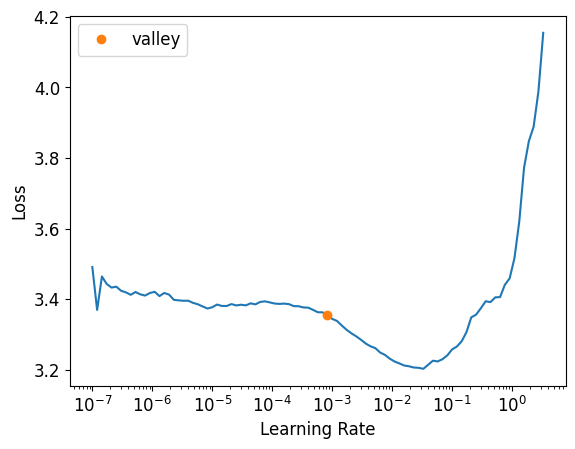

In [ ]:
lr = learn.lr_find()

Parece que valores entre `1e-3` y `1e-2` son adecuados para el entrenamiento. El valor que nos sugiere la función parece bastante pequeño. Por lo que elegimos el máximo valor que podemos elegir, que es `1e-2`, ya que se encuentra en una pendiente decreciente de la función de pérdida.

Nótese que es el mayor valor que hemos podido elegir en toda la práctica, lo cual es acorde a lo que teóricamente permitía Batch Normalization.



In [ ]:
learn.fit_one_cycle(25, lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,2.499997,2.392896,0.256800,0.319969,0.256800,0.238006,00:15
1,2.142002,1.987421,0.396800,0.439221,0.396800,0.381567,00:15
2,2.182020,1.975162,0.383200,0.428188,0.383200,0.363996,00:16
3,2.062239,1.825733,0.427200,0.469966,0.427200,0.407624,00:16
4,1.962044,1.769978,0.452000,0.524534,0.452000,0.450704,00:15
5,1.916978,1.932720,0.388800,0.439521,0.388800,0.361647,00:16
6,1.775233,1.618234,0.484800,0.505054,0.484800,0.460593,00:15
7,1.719091,1.628803,0.487200,0.515797,0.487200,0.463438,00:16
8,1.634003,1.450426,0.536000,0.573325,0.536000,0.526475,00:15
9,1.468035,1.413903,0.549600,0.575589,0.549600,0.538210,00:15


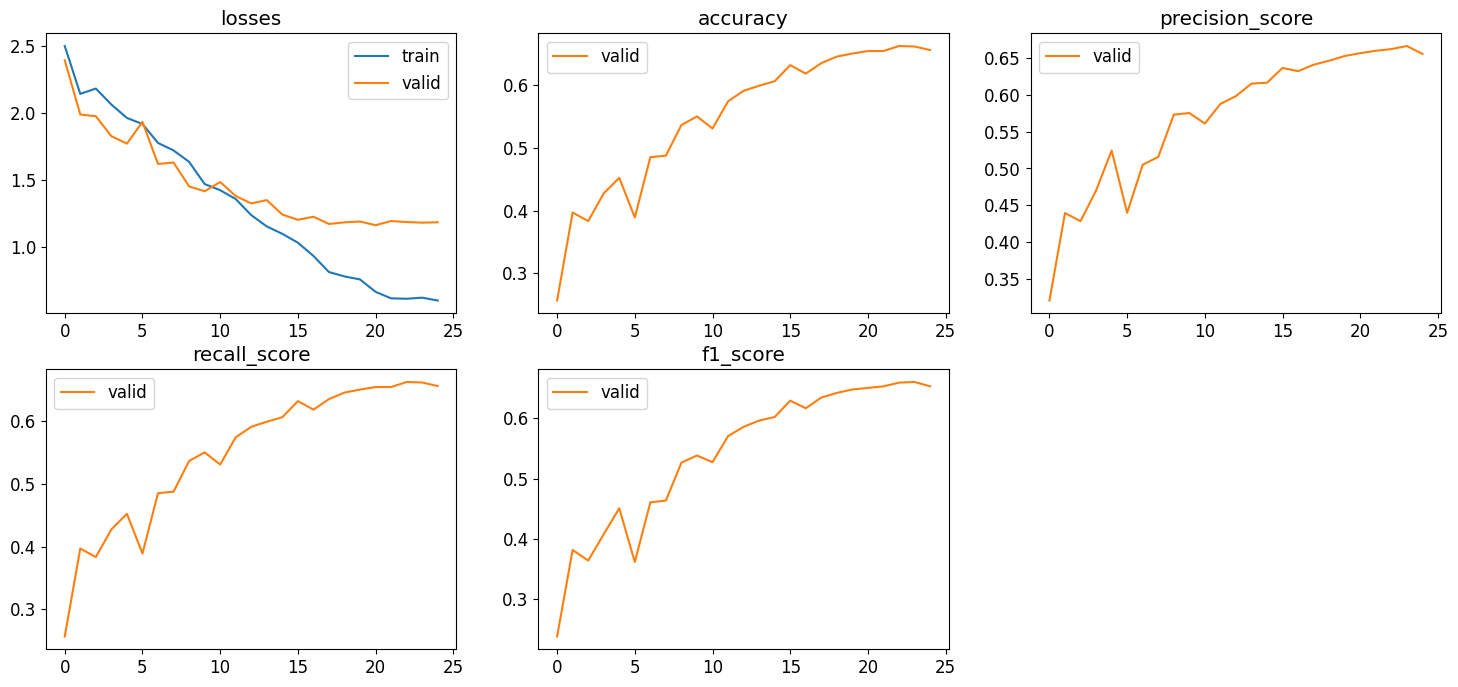

In [ ]:
learn.recorder.plot_metrics()

Podemos comprobar en la curva de aprendizaje que, aunque el modelo mejora mucho respecto al modelo sin BN, sigue existiendo bastante sobreaprendizaje. A partir de la época 10, la pérdida en entrenamiento continúa disminuyendo al mismo ritmo, mientras que en validación la mejora es a un ritmo mucho menor.

A pesar del sobreentrenamiento, el modelo consigue obtener en entrenamiento una pérdida de 0.60, mientras que antes obtenía 0.77. En validación, la mejora es mayor incluso, reduciéndose de 1.44 a 1.18.

Se podría entrenar durante algunas épocas el modelo, porque parece que podría mejorar un poco más, pero preferimos quedarnos así para comparar en igualdad de condiciones con BaseNet.  

En cuanto al resto de métricas, como en anteriores casos, todas tienen un valor muy similar en todas las épocas. En las primeras épocas, todas las métricas oscilan bastante, hasta la época 15, donde todas comienzan a estabilizarse. Todas las métricas acaban superando $0.65$.

Para poner un poco en contexto este valor, como tenemos 1250 imágenes en validación, aproximadamente nuestra red predice la etiqueta correcta para 812 imágenes. Siendo un problema con 25 etiquetas posibles, parece un rendimiento bastante aceptable para una red que no llega al millón de parámetros.

Ya que hemos comentado el valor de accuracy en validación, veamos que valor obtiene el modelo en entrenamiento:

In [ ]:
preds, targs = learn.get_preds(dl=dls.train)
train_accuracy = accuracy(preds, targs)
print(f'Accuracy en entrenamiento = {train_accuracy.item()}')

preds, targs = learn.get_preds(dl=dls.valid)
val_accuracy = accuracy(preds, targs)
print(f'Accuracy en validación = {val_accuracy.item()}')

Accuracy en entrenamiento = 0.9495999813079834


Accuracy en validación = 0.6552000045776367


Comprobamos que en entrenamiento el modelo consigue clasificar correctamente casi el $95\%$ de las imágenes. Es decir, el modelo es prácticamente perfecto en los datos de entrenamiento.

Sin embargo, el modelo no generaliza tan bien al conjunto de validación, ya que en validación únicamente obtenía un $65\%$ (~$30\%$ de diferencia). Vemos aquí perfectamente reflejado el overfitting que sufre el modelo, a pesar de obtener un valor de accuracy elevado en ambos conjuntos.

Veamos dónde comete los errores nuestro modelo analizando la matriz de confusión, tanto en entrenamiento como en validación:

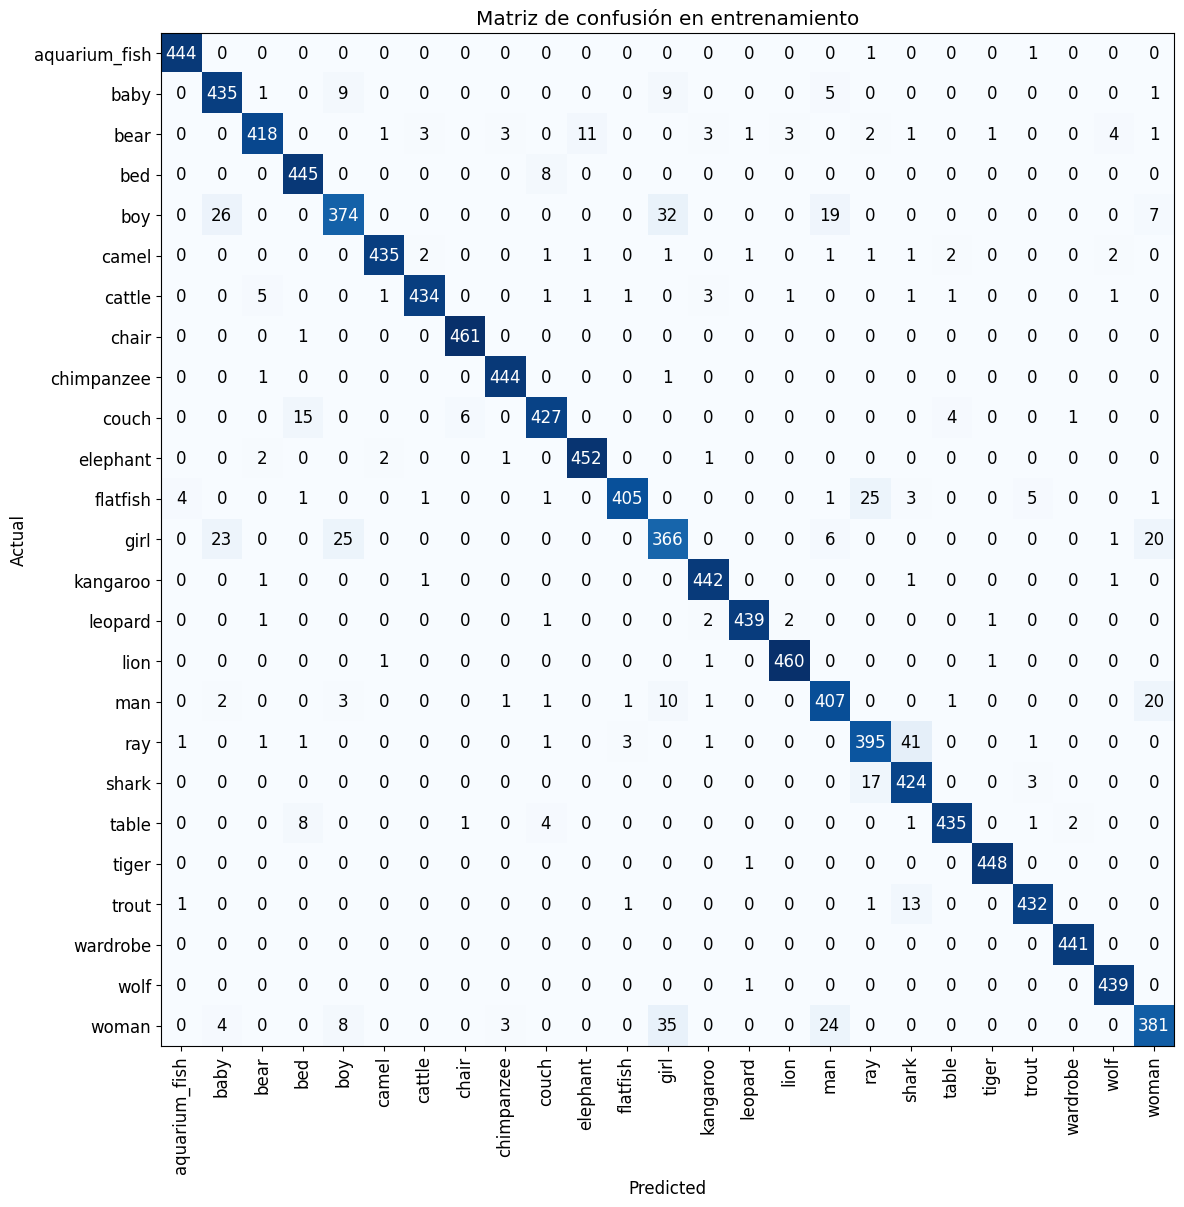

In [ ]:
# ENTRENAMIENTO --> ds_idx = 0
interp = ClassificationInterpretation.from_learner(learn, ds_idx=0)
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en entrenamiento')

Esta matriz es muy distinta de las analizadas en el ejercicio 1. Observamos una diagonal (aciertos), donde se concentran la mayor parte de imágenes.

En la mayoría de clases, hay menos de 15 imágenes clasificadas incorrectamente. Hay pocas zonas fuera de la diagonal con muchas imágenes.

Además, a nivel explicativo, podemos entender la mayoría de fallos, como confundir imágenes de una chica (girl) con una mujer (woman), confundir un chico (boy) con un bebé (baby), o un pez plano (flatfish) con una raya (ray).

Esto se puede ver mejor gráficamente representando las imágenes que más pérdida provocan:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


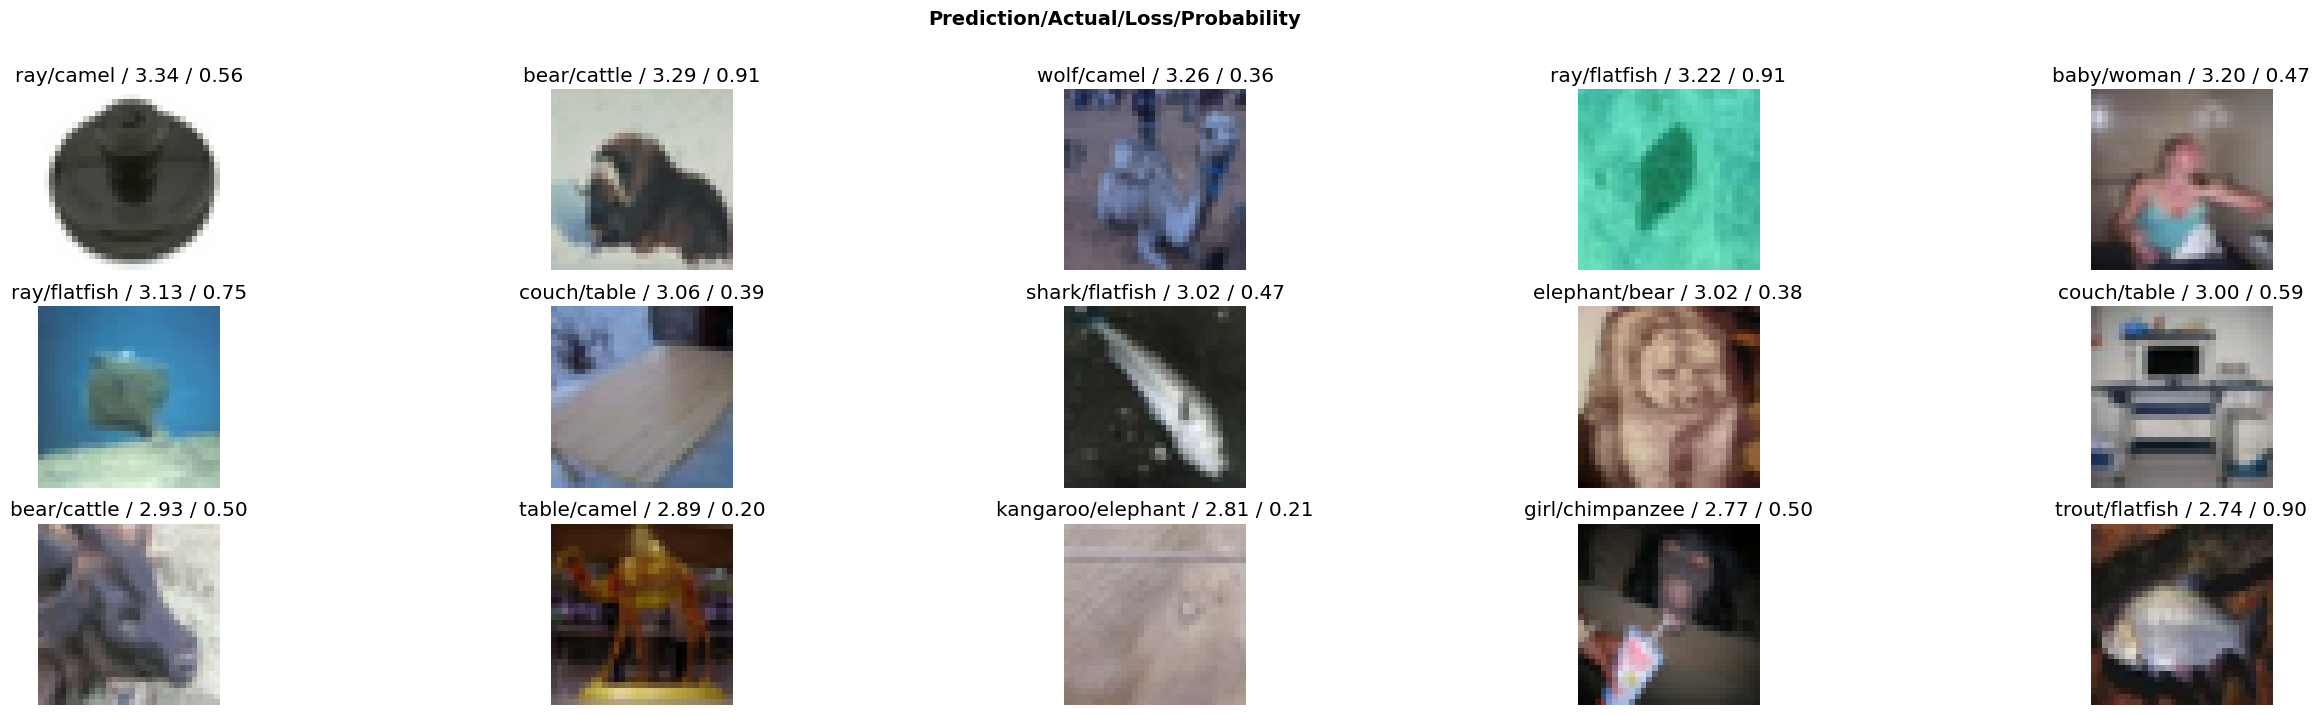

In [ ]:
interp.plot_top_losses(15, nrows=3, figsize=(32,8))

Como decíamos, muchos errores los cometería incluso un ser humano si le pedimos que identifique las imágenes.

Por comentar algunas imágenes, por ejemplo, la primera imagen de la segunda fila (donde se predice una raya y realmente es un pez plano) podría ser una raya si le preguntáramos a algún humano. En otras imágenes, simplemente es complicado hasta para una persona saber qué hay en la imagen, como en la primera imagen de la primera fila, o en la tercera imagen de la tercera fila.

Pasamos a analizar los errores en el conjunto de validación.

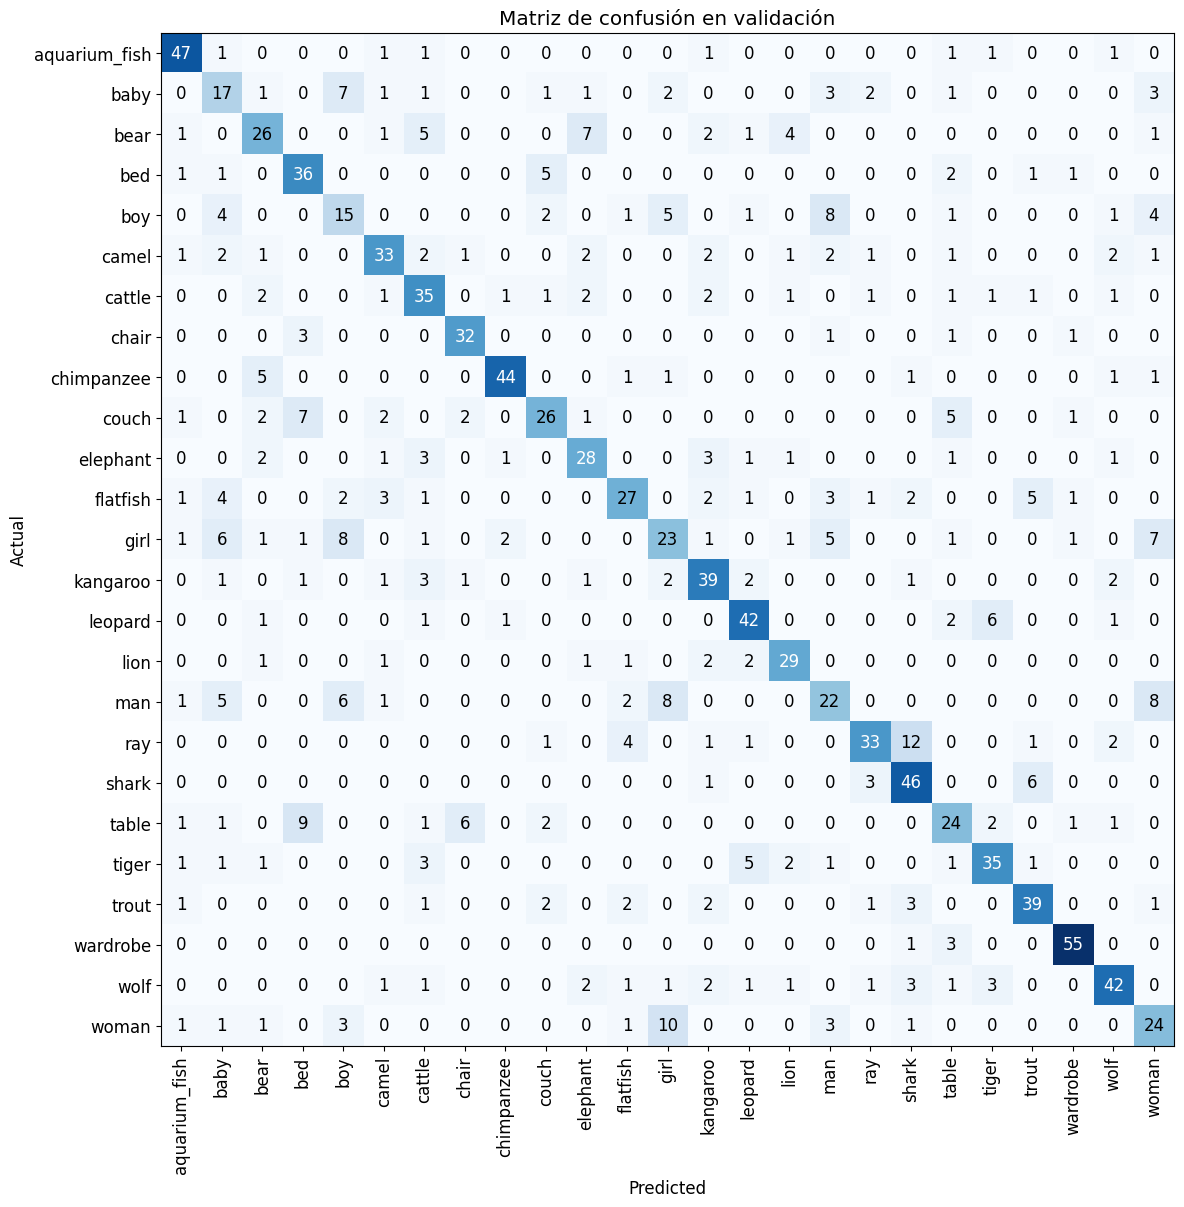

In [ ]:
# Validación --> ds_idx = 1
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en validación')

Si comparamos con la matriz obtenida en entrenamiento, la diagonal tiene un menor número de imágenes. Los clases que se confunden en entrenamiento se siguen confundiendo también en validación. Sin embargo, aparecen varias zonas fuera de la diagonal de clases que apenas se confundían en entrenamiento, pero en validación sí, como chimpanzee-bear o tiger-leopard.

Si comparamos con la matriz obtenida en validación en el ejercicio 1, la diferencia es asombrosa. Fuera de la diagonal, ahora encontramos menos valores distintos de ceros y de hecho, no encontramos casos de clases que se confundan con todas las clases restantes, a diferencia de lo que ocurría en el ejercicio anterior. Además, en BaseNet había varias clases (couch, boy, flatfish) para las que había 5 o menos imágenes clasificadas correctamente. Ahora, todas las clases tienen 15 o más.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


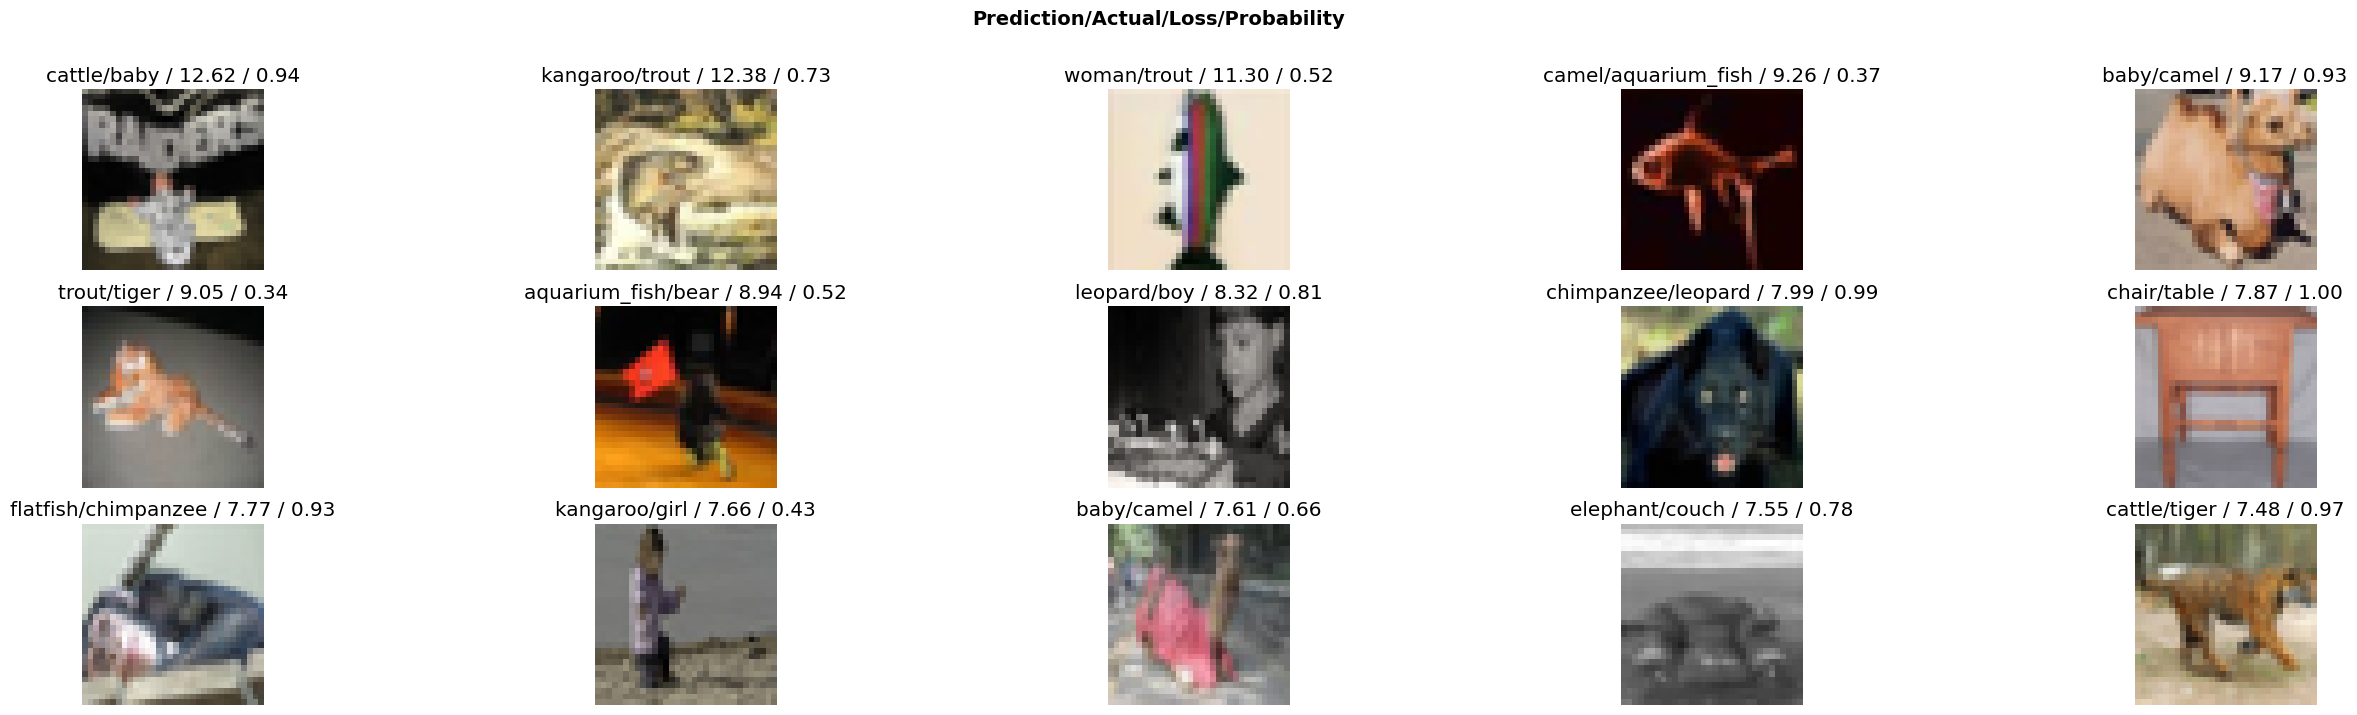

In [ ]:
interp.plot_top_losses(15, nrows=3, figsize=(32,8))

A pesar de la mejora, la red comete errores similares a los del ejercicio 1. Como ya hemos comentado varias veces, la mayoría de ellos son complicados de entender.

Resulta también sorprendente que en muchas de las predicciones la red está prácticamente segura de esta predicción, como en el caso de la primera imagen de la tercera fila (flatfish con probabilidad 0.93) o la cuarta imagen de la tercera fila (elephant con probabilidad 0.78).

### 2.5.1 - Validación en el conjunto de test

Pasamos ya finalmente a validar el modelo con el conjunto de test.
Recuperamos los datos de test (se aplica implícitamente la normalización, sin recalcular los parámetros, que realizamos a los datos en el primer apartado), y calculamos la precisión del modelo:

In [ ]:
dls_test = learn.dls.test_dl(files_test, with_labels = True)

preds, targs, _ = learn.get_preds(dl = dls_test, with_decoded = True)
test_accuracy = accuracy(preds, targs)
print(f'Accuracy en test = {test_accuracy.item()}')

Accuracy en test = 0.6344000101089478


Obtenemos aproximadamente un $63\%$ de accuracy, rendimiento muy similar al obtenido en el conjunto de validación (de forma similar a lo que ocurría en el ejercicio 1).

Parece, por lo tanto, que el conjunto de test y el de validación son conjuntos bastante similares, por lo que parece que los resultados obtenidos en test serán bastante similares a los obtenidos en validación.

Veamos, por tanto la matriz de confusión:

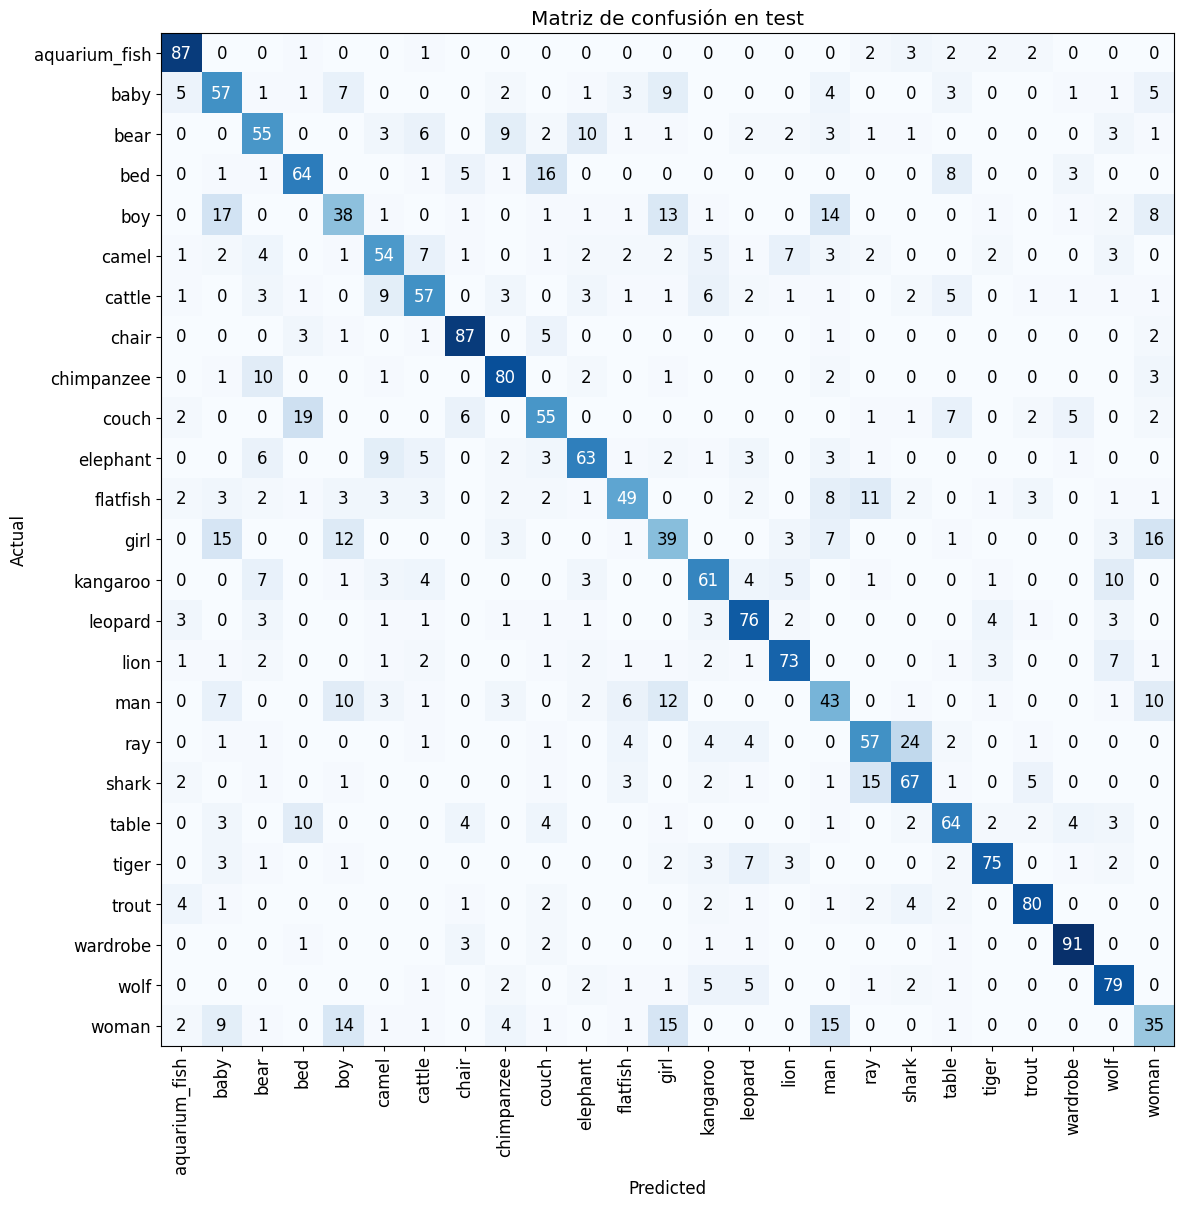

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, dl = dls_test)
interp.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en test')

Podemos comprobar que la mayoría de zonas distintas de 0 fuera de la diagonal que encontrábamos en validación aquí también aparecen. Lo que quizá resulta más llamativo son algunas clases que no se confundían apenas en validación y aquí se confunden bastante.

Por ejemplo, la clase bear con chimpanzee (0 errores en validación, 9 en test), o la clase camel con lion (1 error en validación, 7 en test).

Por lo demás, las matrices de validación y test son muy similares, aunque con valores algo más elevados en zonas fuera de la diagonal en test.

## 2.6 - Cálculo de parámetros del modelo

Calculemos el número de parámetros de nuestro modelo:

| Tipo de Capa  | Tamaño del Kernel (para capas convolucionales) | Dimensión de Entrada | Dimensión de Salida | Canales de Entrada | Canales de Salida |
|----------------|-----------------------------------------------|----------------------|---------------------|---------------------|-------------------|
| Conv           | 3x3                                           | 32x32                | 32x32               | 3                   | 32                 |
| Batch Normalization           | -                                           | 32x32                | 32x32               | -                   | -                 |
| ReLU            | -                                             | 32x32                | 32x32               | -                   | -                 |
| Conv           | 3x3                                           | 32x32                | 32x32               | 32                   | 64                 |
| Batch Normalization           | -                                           | 32x32                | 32x32               | -                   | -   
| ReLU            | -                                             | 32x32                | 32x32               | -                   | -                 |
| MaxPooling     | 2x2                                           | 32x32                | 16x16              | -                   | -                 |
| Conv           | 3x3                                          | 16x16                | 16x16                 | 64                   | 128                |
| Batch Normalization           | -                                           | 16x16                | 16x16               | -                   | -   
| ReLU            | -                                             | 16x16                  | 16x16                 | -                   | -                 |
| MaxPooling     | 2x2                                           | 16x16                | 8x8              | -                   | -                 |
| Conv           | 3x3                                          | 8x8                | 8x8                 | 128                   | 128                |
| Batch Normalization           | -                                           | 8x8                | 8x8               | -                   | -    
| ReLU            | -                                             | 8x8                  | 8x8                 | -                   | -                 |
| MaxPooling     | 2x2                                           | 8x8                | 4x4              | -                   | -                 |
| Dropout (p=0.5)    | -                                           | 4x4                | 4x4              | -                   | -                 |
| FC             | -                                             | 2048                  | 100                 | -                   | -                 |
| ReLU           | -                                             | 100                  | 100                  | -                   | -                 |
| Dropout (p=0.5)    | -                                           | 100                | 100              | -                   | -                 |
| FC             | -                                             | 100                   | 25                  | -                   | -                |

Procedemos capa por capa:
- **Capa convolucional** (tamaño kernel = 3x3, canales entrada = 3, canales salida = 32):

  Aplicando el proceso explicado en el ejercicio 1, el número de parámetros de esta capa será
  $$
  (\text{tamaño kernel} \cdot \text{canales de entrada} + \text{bias}) \cdot \text{canales salida} = (3\cdot 3 \cdot 3 + 1) \cdot 32 = 896
  $$

- **Batch Normalization** (canales de entrada = 32):

  El número de parámetros será igual a
$$
2\cdot \text{canales de entrada} = 2\cdot 32 = 64
$$

  , ya que ajustaremos los parámetros $\beta$, $\gamma$ para cada canal.

- **ReLU**: no aportan ningún parámetro a la red las funciones de activación.

- **Capa convolucional** (tamaño kernel = 3x3, canales entrada = 32, canales salida = 64):

  $$
  (\text{tamaño kernel} \cdot \text{canales de entrada} + \text{bias}) \cdot \text{canales salida} = (3\cdot 3 \cdot 32 + 1) \cdot 64 = 18496
  $$

- **Batch Normalization** (canales de entrada = 64):
    
  El número de parámetros será igual a
$$
2\cdot \text{canales de entrada} = 2\cdot 64 = 128
$$

- **ReLU**: no aportan ningún parámetro a la red las funciones de activación.

- **Max Pooling**: no aportan ningún parámetro a la red las capas de Pooling.

- **Capa convolucional** (tamaño kernel = 3x3, canales entrada = 64, canales salida = 128):

  $$
  (\text{tamaño kernel} \cdot \text{canales de entrada} + \text{bias}) \cdot \text{canales salida} = (3\cdot 3 \cdot 64 + 1) \cdot 128 = 73856
  $$

- **Batch Normalization** (canales de entrada = 128):

  El número de parámetros será igual a
$$
2\cdot \text{canales de entrada} = 2\cdot 128 = 256
$$

- **ReLU**: no aportan ningún parámetro a la red las funciones de activación.

- **Max Pooling**: no aportan ningún parámetro a la red las capas de Pooling.

- **Capa convolucional** (tamaño kernel = 3x3, canales entrada = 128, canales salida = 128):

  $$
  (\text{tamaño kernel} \cdot \text{canales de entrada} + \text{bias}) \cdot \text{canales salida} = (3\cdot 3 \cdot 128 + 1) \cdot 128 = 147584
  $$

- **Batch Normalization** (canales de entrada = 128):

  El número de parámetros será igual a
$$
2\cdot \text{canales de entrada} = 2\cdot 128 = 256
$$

- **ReLU**: no aportan ningún parámetro a la red las funciones de activación.

- **Max Pooling**: no aportan ningún parámetro a la red las capas de Pooling.

- **Flatten**: no aporta ningún parámetro, ya que simplemente convierte la imagen en un vector 1D.

- **Dropout**: no aporta ningún parámetro, ya que simplemente desactiva aleatoriamente $pn$ entradas.

- **Linear o FC** (número de entradas = 2048, número de salidas = 200):

  El número de parámetros será:
$$
\text{número de entradas} \cdot \text{número de salidas} + \text{bias} = 2048 \cdot 200 + 200 = 409800
$$

- **Batch Normalization 1D** (número de entradas = 200):

  Se ajustan dos parámetros por cada entrada, por tanto
  $$
  2 \cdot \text{número de entradas} = 2 \cdot 200 = 400
  $$

- **ReLU**: no aportan ningún parámetro a la red las funciones de activación.

- **Dropout**: no aporta ningún parámetro, ya que simplemente desactiva aleatoriamente $pn$ entradas.

- **Linear o FC** (número de entradas = 200, número de salidas = 25):

  El número de parámetros será:
$$
\text{número de entradas} \cdot \text{número de salidas} + \text{bias} = 200 \cdot 25 + 25 = 5025
$$

Por tanto, el número total de parámetros de la red será:
$$
896+64+18496+128+73856+256+147584+256+409800+400+5025 = 656761
$$

## 2.7 - Notas y mejoras futuras

En primer lugar, veo necesario comentar que ha habido varios intentos de mejora que no han obtenido el resultado esperado, y por tanto no se han incluido:
- Al último modelo obtenido se le ha intentado añadir una mayor regularización, añadiendo Dropout a algunas o a todas las capas convolucionales, utilizando $p=0.5$ y $p=0.6$ (para reducir la regularización). Se ha cerrado el gap entre entrenamiento y validación, pero se han obtenido peores resultados en general (en torno al 60% de accuracy en validación).
- También se ha intentado usar Data Augmentation, mediante la función `aug_transforms` de FastAI. De nuevo, se ha conseguido cerrar bastante el gap entre entrenamiento y validación, pero se han obtenido peores resultados en general (en torno al 61% de accuracy en validación).
- También se ha intentado, utilizando la implementación explicada en [[11]](https://www.youtube.com/watch?v=vGsc_NbU7xc), incorporar algún tipo de mejora en la inicialización de los pesos, como la inicialización de He [[12]](https://arxiv.org/abs/1502.01852v1), ya que se utilizaba la función ReLU en nuestra red, pero los resultados obtenidos han sido los mismos que sin utilizar la iniciación (~65% de accuracy).

Algunas mejoras que sería interesante implementar en un futuro.:

- Fijándonos en arquitecturas actuales, sería interesante utilizar capas "Global Average Pooling" [[13]](https://arxiv.org/pdf/1312.4400v3), que nos permitan eliminar las capas densas de nuestra red, y reducir en gran medida el número de parámetros. De hecho, puede que así elimináramos cierto overfitting.

- Hay algunos autores que defienden que eliminar gran parte de las capas Pooling de las redes, y disminuir la dimensionalidad usando un mayor stride en algunas capas convolucionales [[14]](https://arxiv.org/pdf/1412.6806), puede llegar a obtener mejores resultados. Es por ello que podría ser interesante probarlo y comprobar los resultados.

